In [1]:
import deepdish.io as io
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
d_eplus = h5py.File('../data/eplus.hdf5', 'r')
d_gamma = h5py.File('../data/gamma.hdf5', 'r')
d_piplus = h5py.File('../data/piplus.hdf5', 'r')
d = d_eplus

In [3]:
matplotlib.__version__ # should be 2.0.0

'2.0.1'

In [4]:
first = d['layer_0'][:]
second = d['layer_1'][:]
third = d['layer_2'][:]

In [5]:
sizes = [first.shape[1], first.shape[2], second.shape[1], second.shape[2], third.shape[1], third.shape[2]]

In [6]:
matplotlib.rcParams.update({'font.size': 50})

In [7]:
def plot_image(image, layer, vmin=None, vmax=None):
    fig = plt.figure(figsize=(20,20))
    plt.imshow(image, aspect=float(sizes[layer*2 + 1])/sizes[layer*2],
               interpolation='nearest', norm=LogNorm(vmin, vmax))
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83)
    cbar.ax.tick_params() #labelsize=30) 
   
    xticks = range(sizes[layer*2 + 1])
    yticks = range(sizes[layer*2])
    if layer == 0:
        xticks = xticks[::10]
    plt.xticks(xticks)#, fontsize=30)
    plt.yticks(yticks)
    plt.xlabel(r'$\eta$ Cell ID')
    plt.ylabel(r'$\phi$ Cell ID')

    plt.tight_layout()
    #return fig

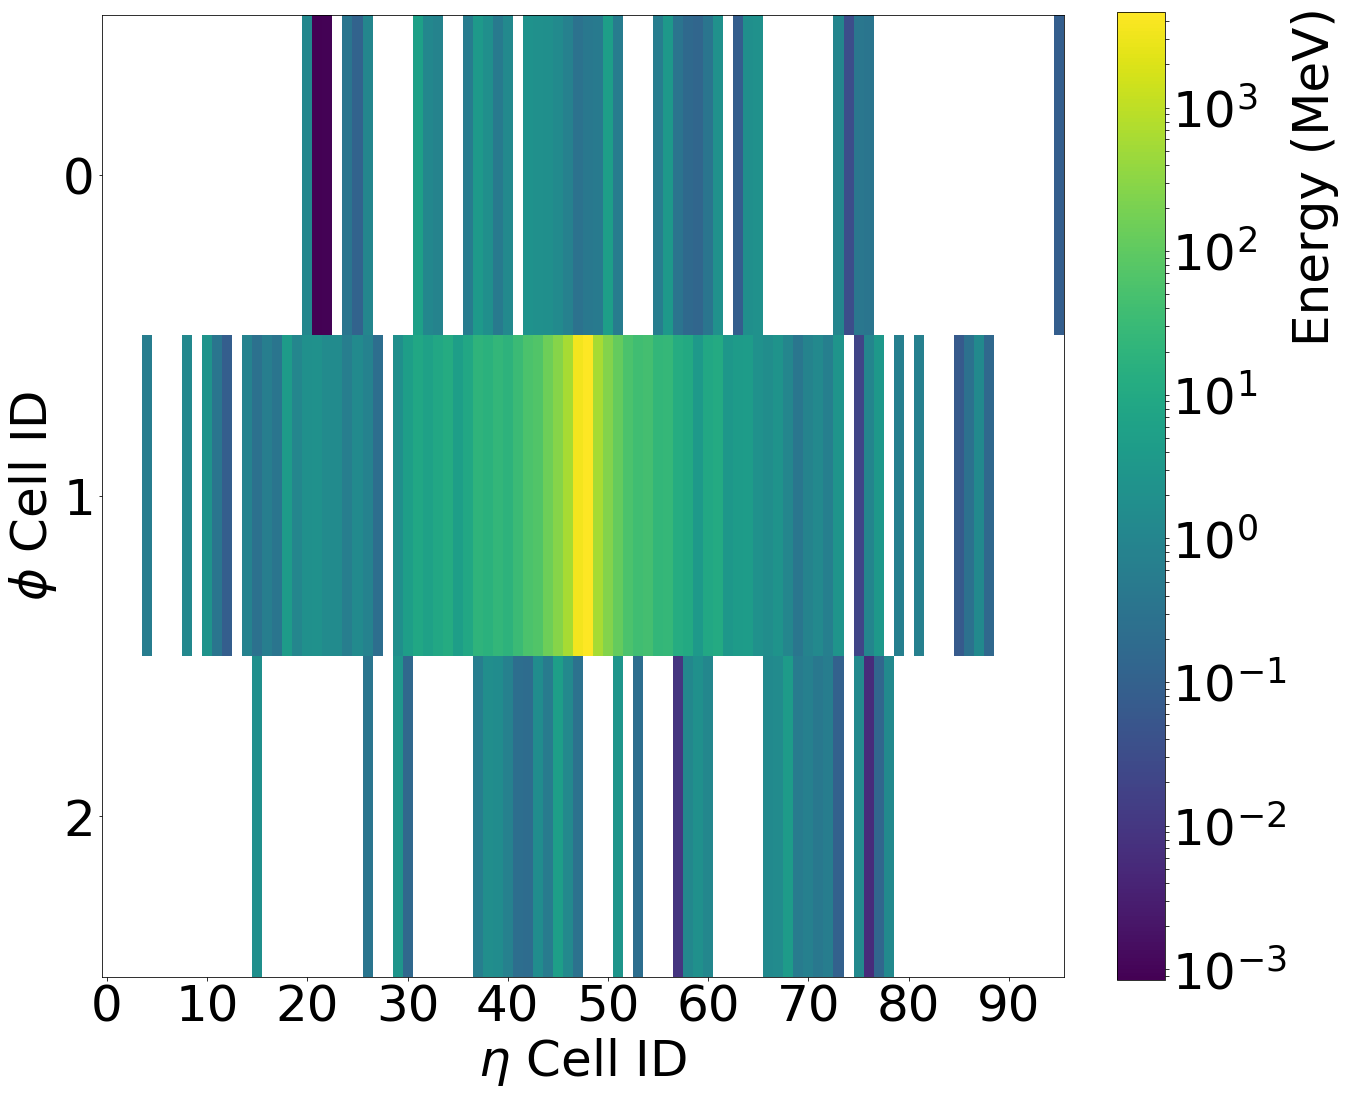

In [8]:
imageix = 0
# plt.figure(figsize=(20,20))
# plt.imshow(first[imageix], aspect=float(first.shape[2])/first.shape[1],
#            interpolation='nearest', norm=LogNorm())
# cbar = plt.colorbar(fraction=0.0455)
# cbar.set_label(r'Energy (MeV)', y=0.85)
# cbar.ax.tick_params()#labelsize=30) 
# plt.xticks(range(first.shape[2])[::10], fontsize=50)
# plt.yticks(range(first.shape[1]))
# plt.xlabel(r'$\eta$ Cell ID')
# plt.ylabel(r'$\phi$ Cell ID')

# plt.tight_layout()
# plt.savefig('0_1.png', transparent=True)
plot_image(first[imageix], layer=0)

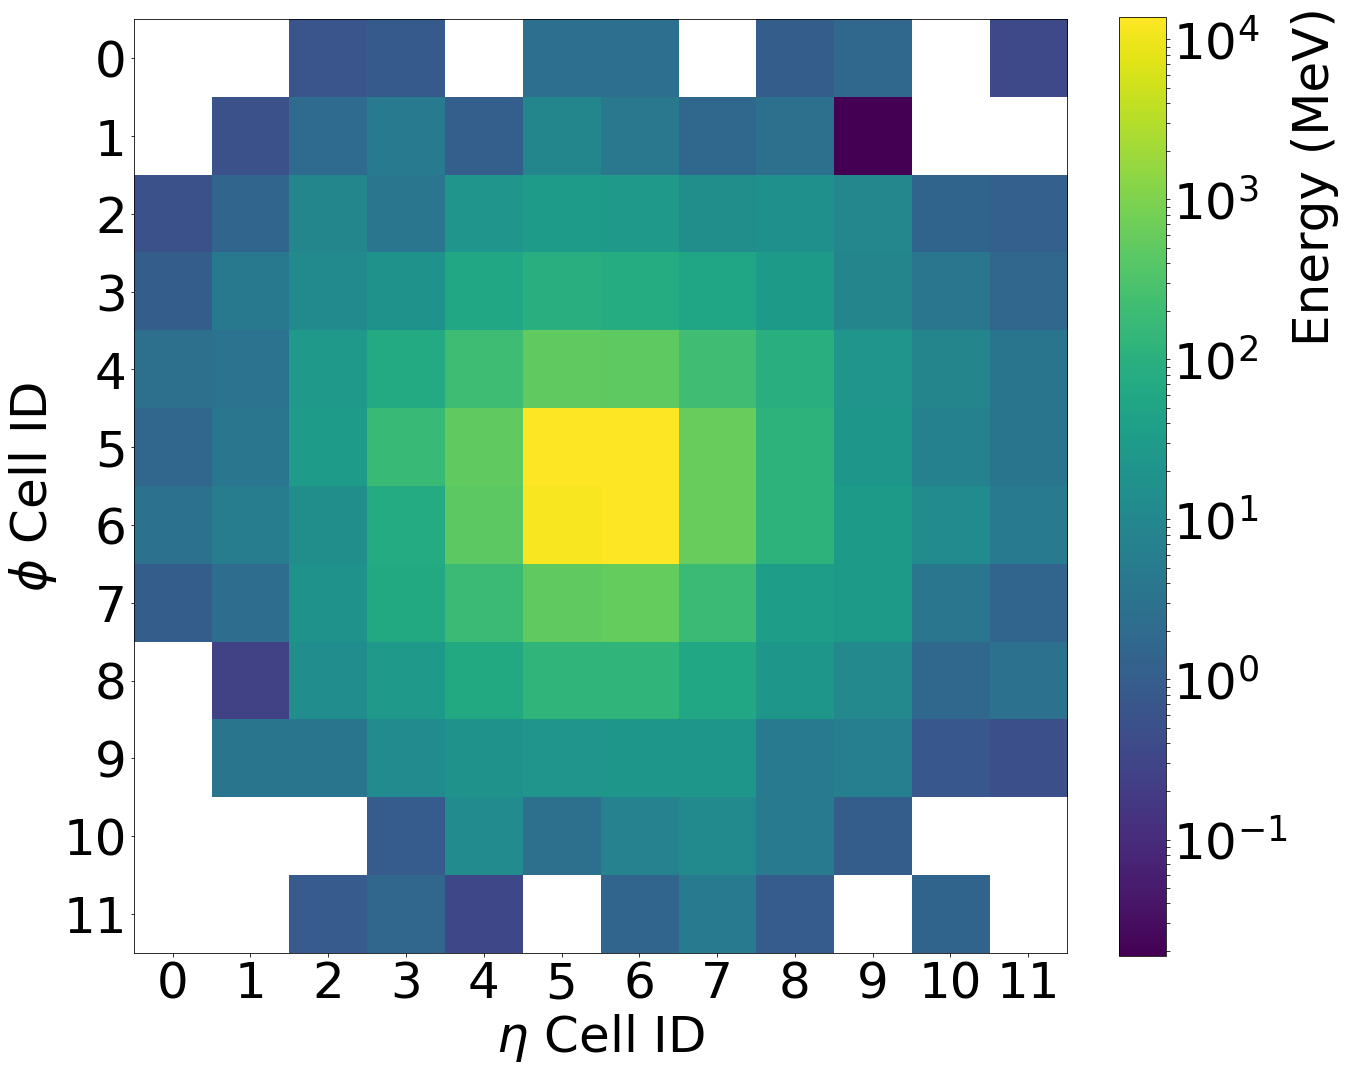

In [9]:
plot_image(second[imageix], layer=1)

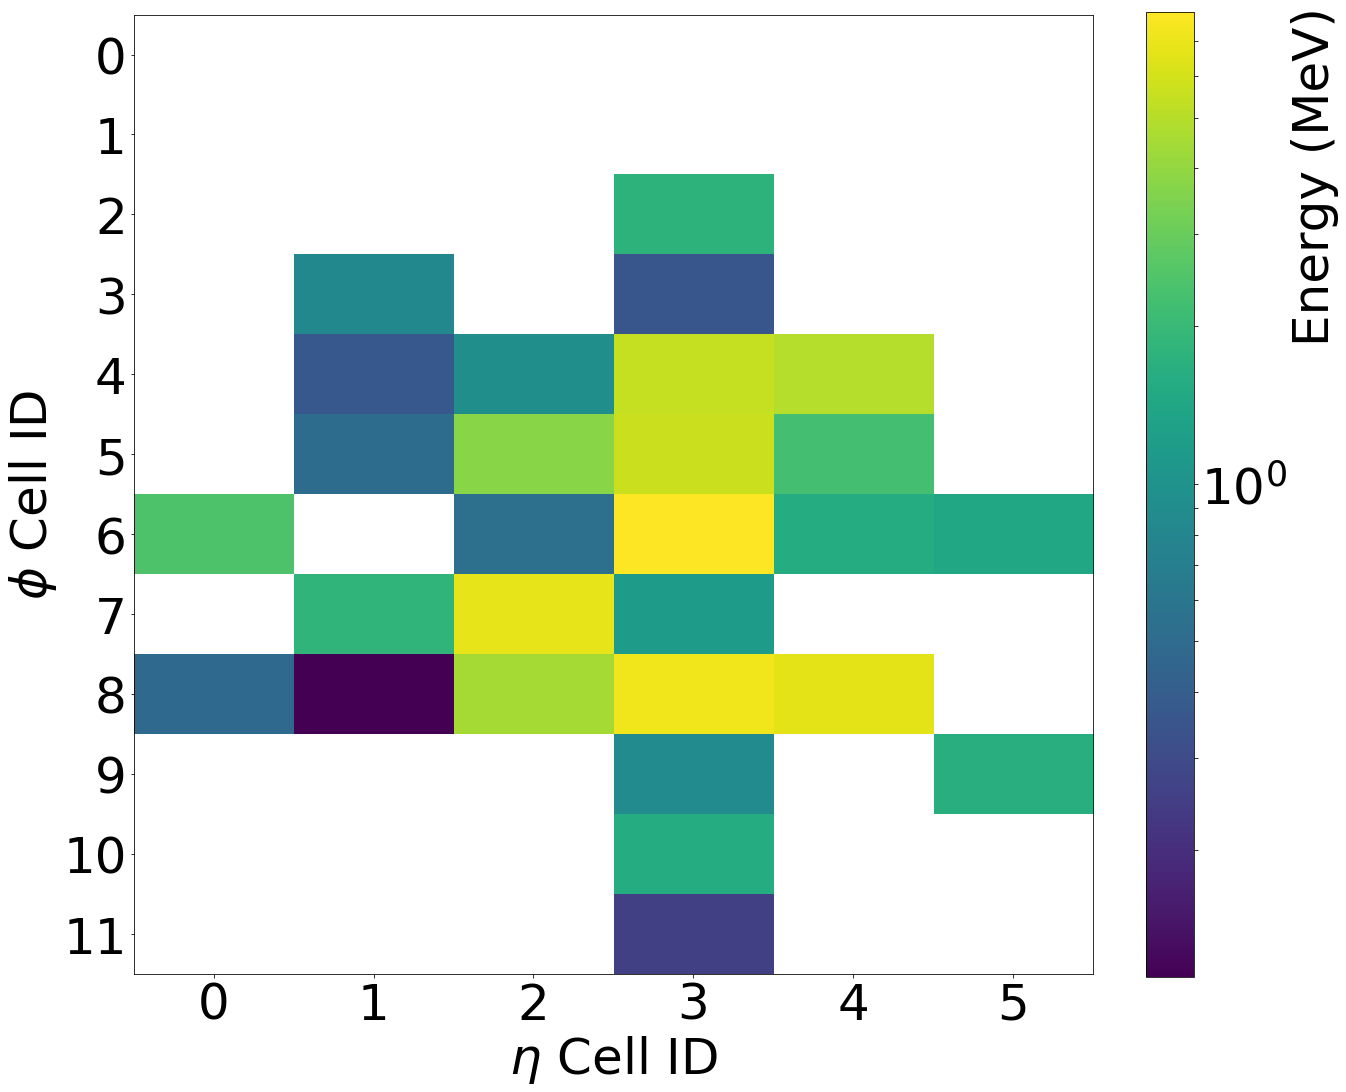

In [10]:
plot_image(third[imageix], layer=2)

In [11]:
latent_size = 1024

In [12]:
noise = np.random.normal(0, 1, (70000, latent_size))
sampled_energy_25 = 25 * np.ones((70000, 1)) #np.random.uniform(1, 100, (70000, 1))
# sampled_energy = np.array([72] * 10000 + [14] * 10000)
sampled_energy_50 = 50 * np.ones((70000, 1)) 
sampled_energy_1 = 1 * np.ones((70000, 1)) 
sampled_energy_100 = 100 * np.ones((70000, 1)) 
sampled_energy_150 = 150 * np.ones((70000, 1)) 

In [13]:
from keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.layers.merge import multiply
import keras.backend as K

Using TensorFlow backend.


In [14]:
import sys
sys.path.append('../')

In [15]:
from models.architectures import build_generator, build_discriminator, determine_energy_distribution, sparse_softmax
from models.ops import scale, inpainting_attention

In [16]:
latent = Input(shape=(latent_size, ), name='z')
input_energy = Input(shape=(1, ), dtype='float32')
generator_inputs = [latent, input_energy]

h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

# h = concatenate([latent, input_energy])

# emb = Flatten()(Embedding(nb_classes, latent_size, input_length=1,
#                           embeddings_initializer='glorot_normal')(image_class))
# # hadamard product between z-space and a class conditional embedding
# h = merge([latent, emb], mode='mul')

img_layer0 = build_generator(h, 3, 96)
img_layer1 = build_generator(h, 12, 12)
img_layer2 = build_generator(h, 12, 6)

if True:

    # inpainting
    zero2one = AveragePooling2D(pool_size=(1, 8))(
        UpSampling2D(size=(4, 1))(img_layer0))
    # final_img_layer1 = add([zero2one, img_layer1])
    img_layer1 = inpainting_attention(img_layer1, zero2one)

    one2two = AveragePooling2D(pool_size=(1, 2))(img_layer1)
    # final_img_layer2 = add([one2two, img_layer2])
    img_layer2 = inpainting_attention(img_layer2, one2two)

generator_outputs = [
    Activation('relu')(img_layer0),
    Activation('relu')(img_layer1),
    Activation('relu')(img_layer2)
]

In [17]:
generator = Model(generator_inputs, generator_outputs)

In [18]:
generator.load_weights('../weights/eplus/g_epoch_049.hdf5')

In [19]:
def generate_samples(klass):
    
    noise = np.random.normal(0, 1, (20000, latent_size))
    sampled_energy = np.random.uniform(1, 100, (20000, 1))
    generator.load_weights('../weights/{}/g_epoch_049.hdf5'.format(klass))
    return generator.predict([noise, sampled_energy], verbose=True, batch_size=1024)

In [ ]:

layer_0 = []
layer_1 = []
layer_2 = []
for klass in ['eplus', 'piplus', 'gamma']:
    gdata = generate_samples(klass)
    layer_0.append(gdata[0])
    layer_1.append(gdata[1])
    layer_2.append(gdata[2])
    

 8192/20000 [===========>..................] - ETA: 0s

In [243]:
# images = generator.predict([noise, sampled_energy], verbose=True, batch_size=1024)
images_1 = generator.predict([noise, sampled_energy_1], verbose=True, batch_size=1024)
images_25 = generator.predict([noise, sampled_energy_25], verbose=True, batch_size=1024)
images_50 = generator.predict([noise, sampled_energy_50], verbose=True, batch_size=1024)
images_100 = generator.predict([noise, sampled_energy_100], verbose=True, batch_size=1024)
images_150 = generator.predict([noise, sampled_energy_150], verbose=True, batch_size=1024)

69632/70000 [============================>.] - ETA: 0s

In [244]:
# first_gan, second_gan, third_gan = map(lambda x: np.squeeze(x * 1000), images)
first_gan_1, second_gan_1, third_gan_1 = map(lambda x: np.squeeze(x * 1000), images_1)
first_gan_25, second_gan_25, third_gan_25 = map(lambda x: np.squeeze(x * 1000), images_25)
first_gan_50, second_gan_50, third_gan_50 = map(lambda x: np.squeeze(x * 1000), images_50)
first_gan_100, second_gan_100, third_gan_100 = map(lambda x: np.squeeze(x * 1000), images_100)
first_gan_150, second_gan_150, third_gan_150 = map(lambda x: np.squeeze(x * 1000), images_150)

In [245]:
# gen_images_eplus = [first_gan, second_gan, third_gan]
gen_images_eplus_1 = [first_gan_1, second_gan_1, third_gan_1]
gen_images_eplus_25 = [first_gan_25, second_gan_25, third_gan_25]
gen_images_eplus_50 = [first_gan_50, second_gan_50, third_gan_50]
gen_images_eplus_100 = [first_gan_100, second_gan_100, third_gan_100]
gen_images_eplus_150 = [first_gan_150, second_gan_150, third_gan_150]

In [236]:
real_images_eplus = [first, second, third]

In [237]:
vmin = [first.mean(axis=0).min(), second.mean(axis=0).min(), third.mean(axis=0).min()]
vmax = [first.mean(axis=0).max(), second.mean(axis=0).max(), third.mean(axis=0).max()]

In [246]:
dgen_eplus_1 = {
    'layer_0' : np.squeeze(gen_images_eplus_1[0]),
    'layer_1' : np.squeeze(gen_images_eplus_1[1]),
    'layer_2' : np.squeeze(gen_images_eplus_1[2])
}
dgen_eplus_25 = {
    'layer_0' : np.squeeze(gen_images_eplus_25[0]),
    'layer_1' : np.squeeze(gen_images_eplus_25[1]),
    'layer_2' : np.squeeze(gen_images_eplus_25[2])
}
dgen_eplus_50 = {
    'layer_0' : np.squeeze(gen_images_eplus_50[0]),
    'layer_1' : np.squeeze(gen_images_eplus_50[1]),
    'layer_2' : np.squeeze(gen_images_eplus_50[2])
}
dgen_eplus_100 = {
    'layer_0' : np.squeeze(gen_images_eplus_100[0]),
    'layer_1' : np.squeeze(gen_images_eplus_100[1]),
    'layer_2' : np.squeeze(gen_images_eplus_100[2])
}
dgen_eplus_150 = {
    'layer_0' : np.squeeze(gen_images_eplus_150[0]),
    'layer_1' : np.squeeze(gen_images_eplus_150[1]),
    'layer_2' : np.squeeze(gen_images_eplus_150[2])
}

In [248]:
c = matplotlib.cm.plasma(np.linspace(0.2, 0.8, 5))

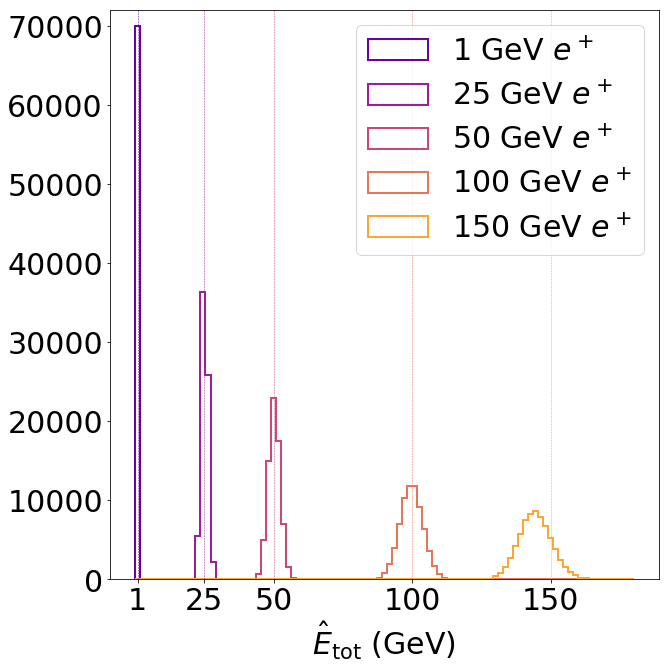

In [269]:
matplotlib.rcParams.update({'font.size': 30})
bins = np.linspace(0, 180, 100)
# bins = np.linspace(70000, 75000, 50)
plt.figure(figsize=(10, 10))

_ = plt.hist(total_energy(dgen_eplus_1) / 1000, bins=bins, histtype='step', linewidth=2,
             alpha=1, color=c[0],
             label=r'1 GeV $e^+$')
_ = plt.hist(total_energy(dgen_eplus_25) / 1000, bins=bins, histtype='step', linewidth=2,
             alpha=1, color=c[1],
             label=r'25 GeV $e^+$')
_ = plt.hist(total_energy(dgen_eplus_50) / 1000, bins=bins, histtype='step', linewidth=2,
             alpha=1, color=c[2],
             label=r'50 GeV $e^+$')
_ = plt.hist(total_energy(dgen_eplus_100) / 1000, bins=bins, histtype='step', linewidth=2,
             alpha=1, color=c[3],
             label=r'100 GeV $e^+$')
_ = plt.hist(total_energy(dgen_eplus_150) / 1000, bins=bins, histtype='step', linewidth=2,
             alpha=1, color=c[4],
             label=r'150 GeV $e^+$')

plt.vlines(1, 0, 72000, linestyle='dashed', color=c[0], linewidth=0.5)
plt.vlines(25, 0, 72000, linestyle='dashed', color=c[1], linewidth=0.5)
plt.vlines(50, 0, 72000, linestyle='dashed', color=c[2], linewidth=0.5)
plt.vlines(100, 0, 72000, linestyle='dashed', color=c[3], linewidth=0.5)
plt.vlines(150, 0, 72000, linestyle='dashed', color=c[4], linewidth=0.5)


plt.legend(loc='upper right', ncol=1)
# plt.yscale('log')
plt.ylim(ymax=72000)
plt.xlabel(r'$\hat{E}_\mathrm{tot}$ (GeV)')
plt.xticks([1, 25, 50, 100, 150])
plt.tight_layout()
plt.savefig('etot_singlerequest.pdf')

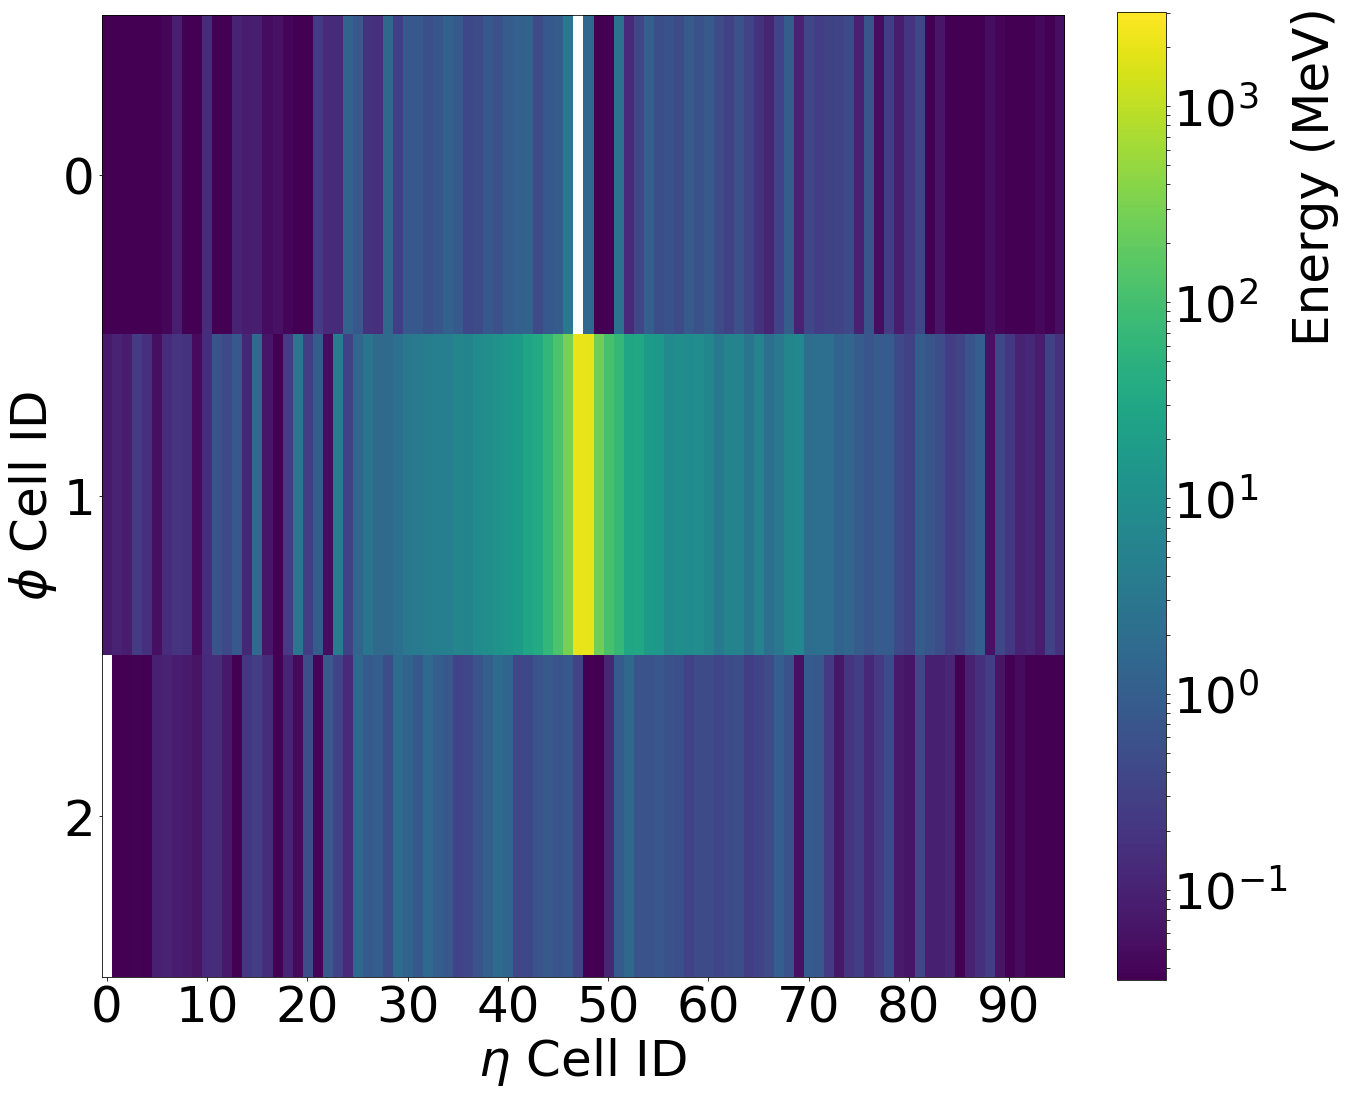

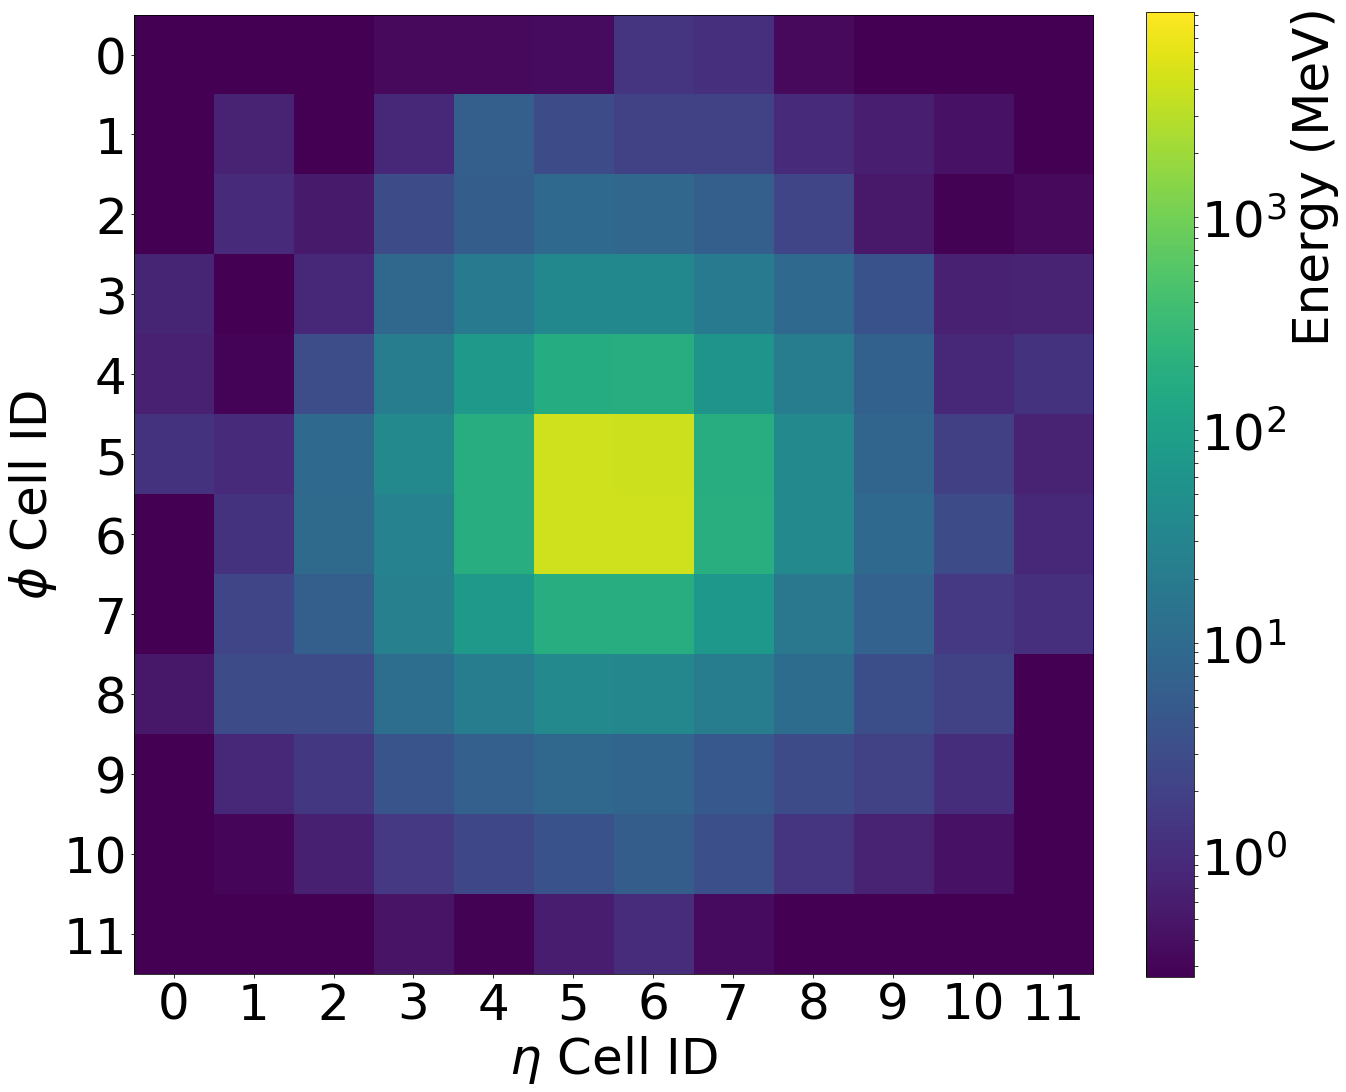

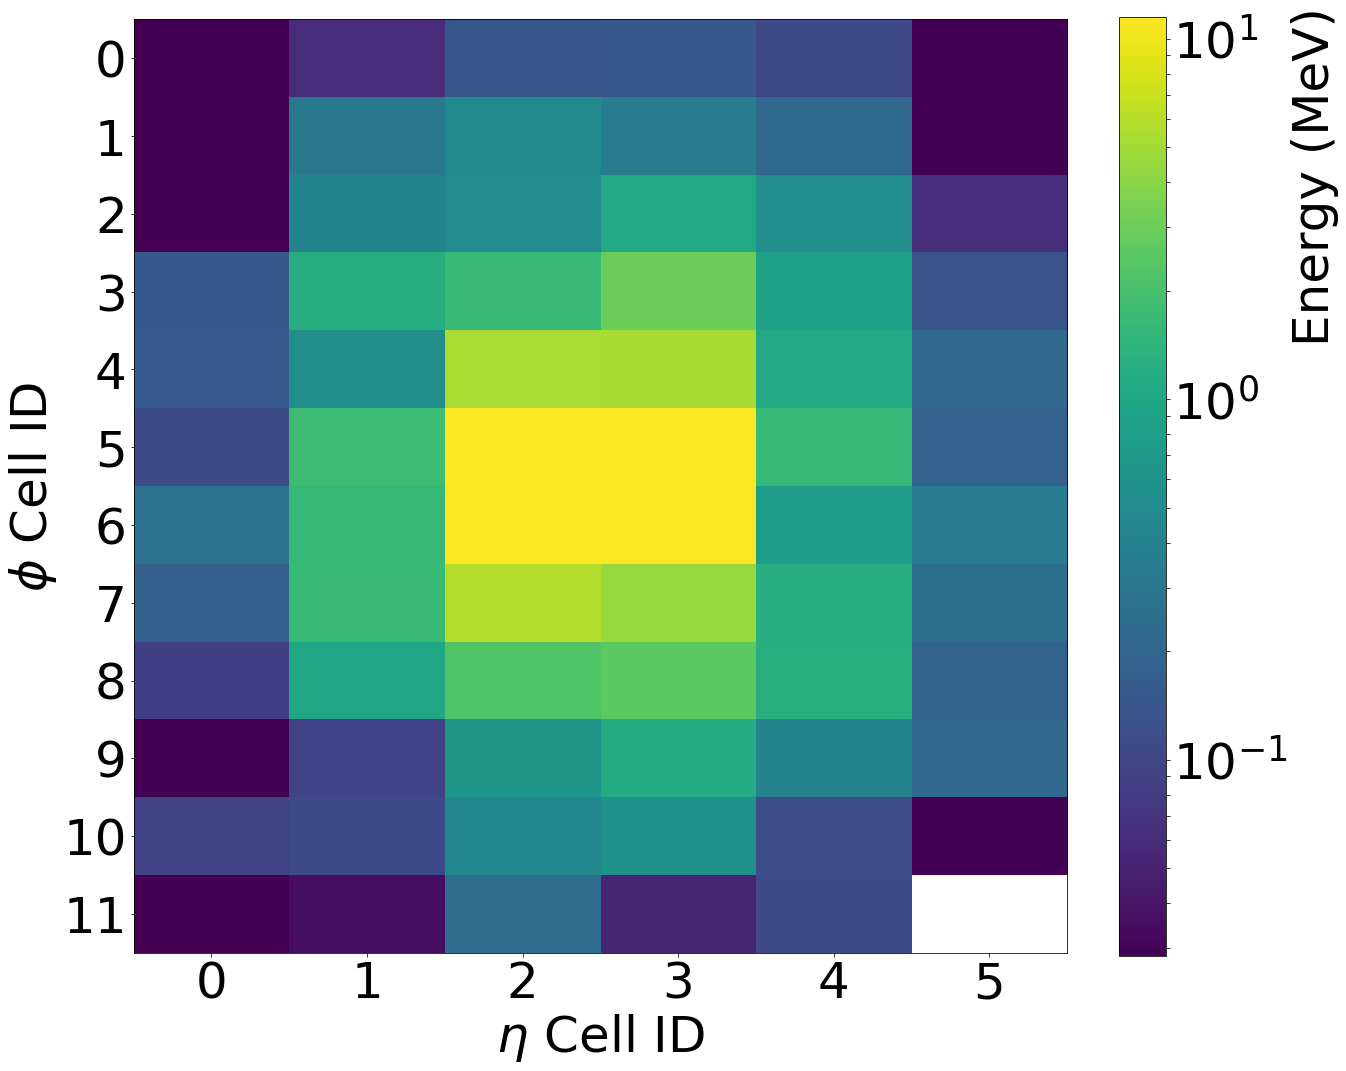

In [238]:
for i in xrange(3):
    plot_image(np.squeeze(gen_images_eplus[i]).mean(axis=0),
               layer=i,
               vmin=vmin[i],
               vmax=vmax[i]
    )
    #plt.savefig('eplus_{}.pdf'.format(i), transparent=True)

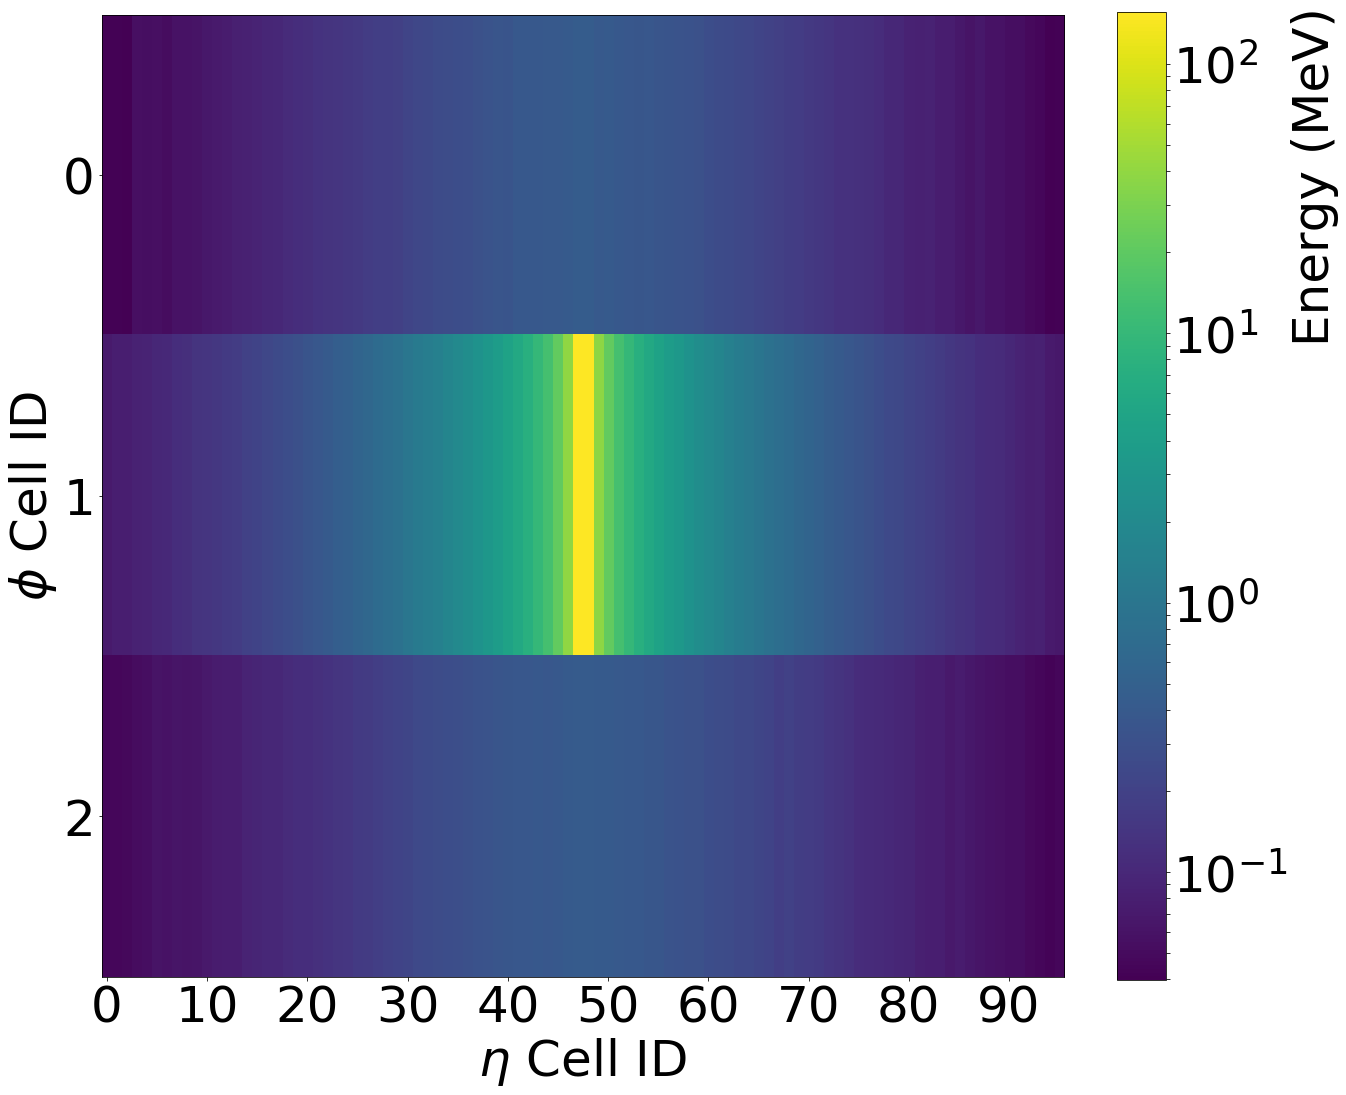

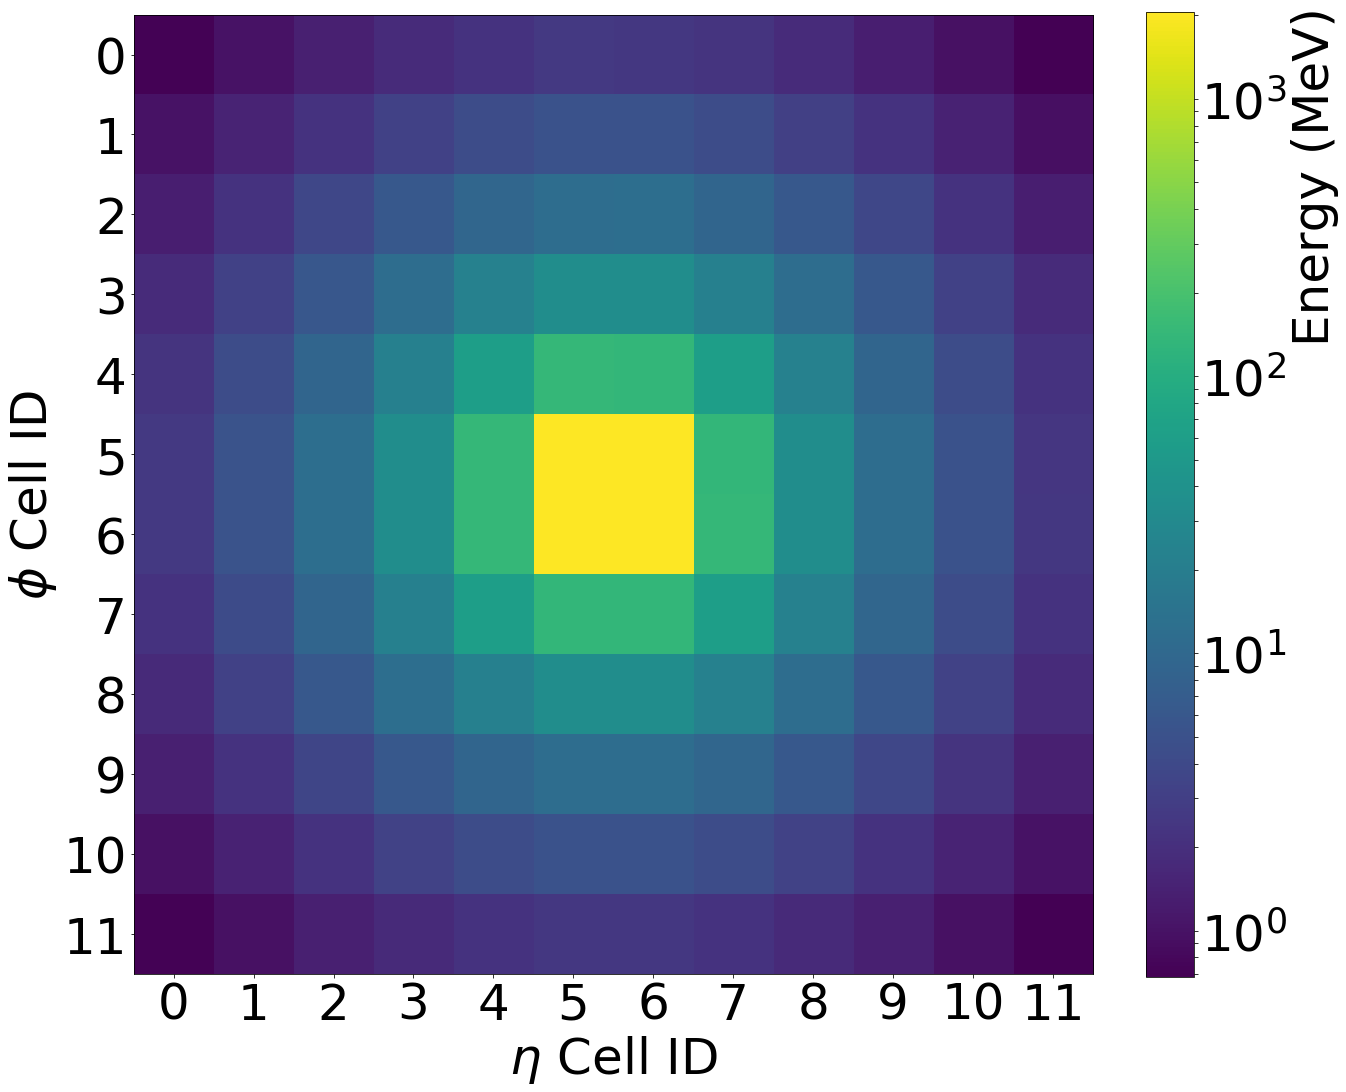

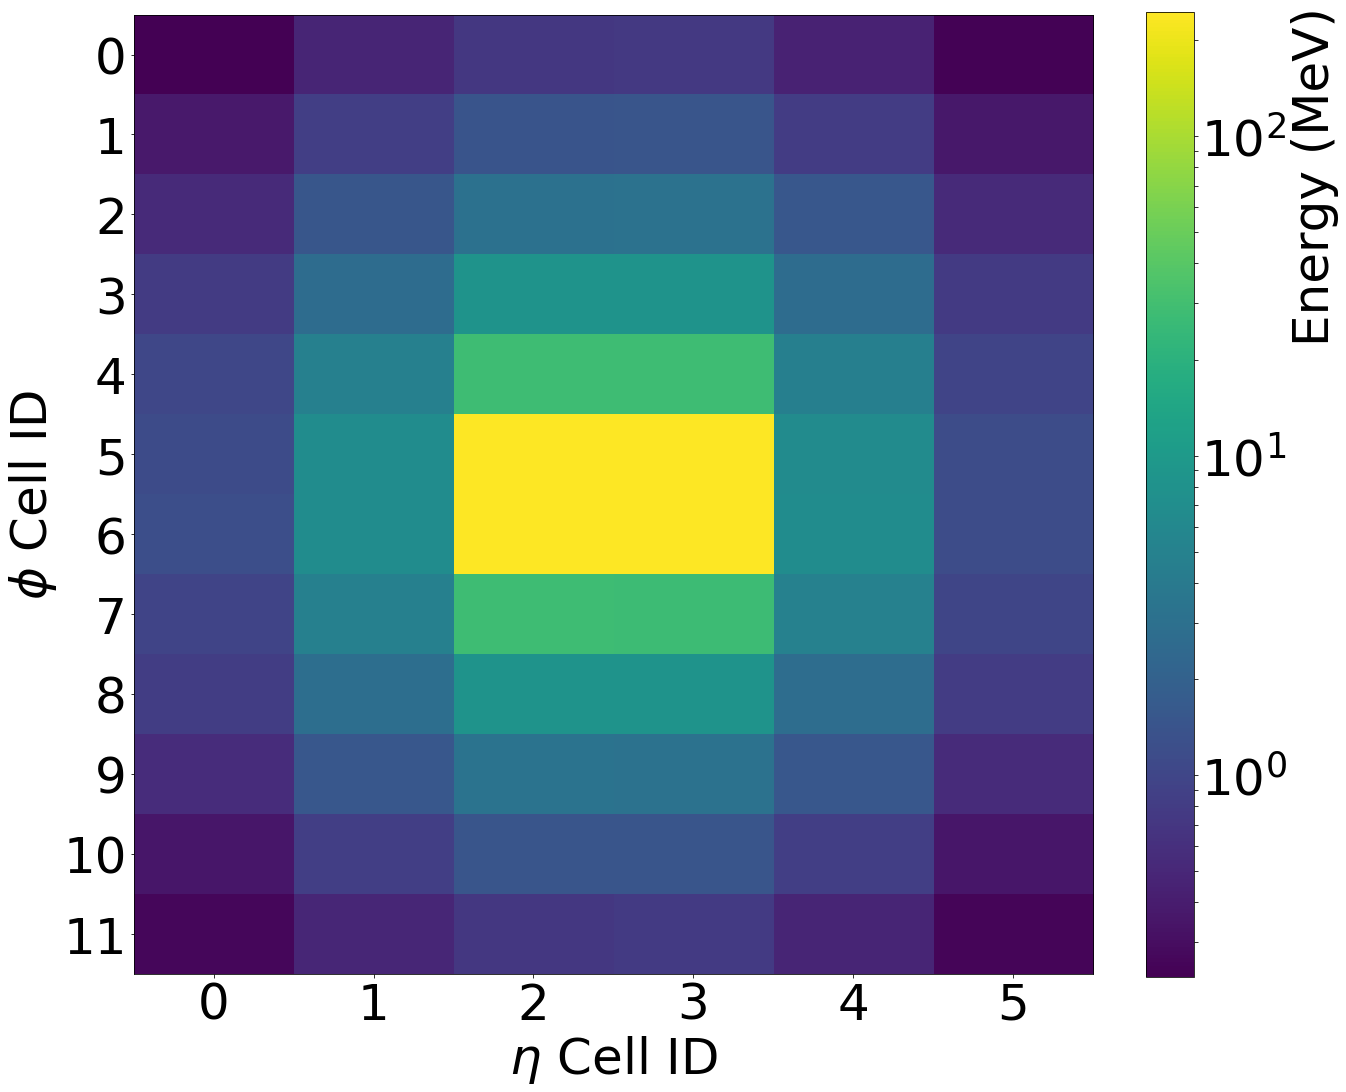

In [68]:
for i in xrange(3):
    plot_image(np.squeeze(real_images_eplus[i][:70000]).mean(axis=0), layer=i)
    plt.savefig('eplus_{}_geant.pdf'.format(i), transparent=True)

In [69]:
def plot_nn(layer, gen_images=gen_images_eplus, real_images=real_images_eplus, vmin=vmin, vmax=vmax, sizes=sizes, nparticles=5):
    '''
    vmin and vmax are the arrays defined above based on GEANT image ranges
    sizes is also defined above
    '''
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(1, metric='euclidean')
    nn.fit(gen_images[layer].reshape(gen_images[layer].shape[0], -1))
    f, axarr = plt.subplots(2, nparticles, figsize=(25, 10))
    particles = np.random.randint(low=0, high=real_images[layer].shape[0], size=nparticles)

    for i, sel in enumerate(particles):
        nbr = int(nn.kneighbors(real_images[layer][sel].ravel().reshape(1, -1))[-1])
        def _plot_im(n_row, images):
            im = axarr[n_row, i].imshow(images,
                                        interpolation='nearest',
                                        norm=LogNorm(vmin=vmin[layer], vmax=vmax[layer]),
                                        aspect=sizes[1+(layer*2)] / float(sizes[(0)+(layer*2)]),
                                       )
            axarr[n_row, i].tick_params(axis='both', which='both', bottom='off', top='off',
                                    left='off', right='off', labelbottom='off',
                                    labelleft='off')
            return im

        cnv = [_plot_im(*content) for content in enumerate([real_images[layer][sel], gen_images[layer][nbr]])]
    axarr[0][0].set_ylabel('GEANT')
    axarr[1][0].set_ylabel('GAN')
    cax = f.add_axes([0.93, 0.11, 0.03, 0.8])
    cb = f.colorbar(cnv[0], cax=cax)
    cb.set_label(r'Energy (MeV)', y=0.73)
    plt.savefig('eplus_nn{}.pdf'.format(layer), pad_inches=2, transparent=True, bbox_inches='tight')

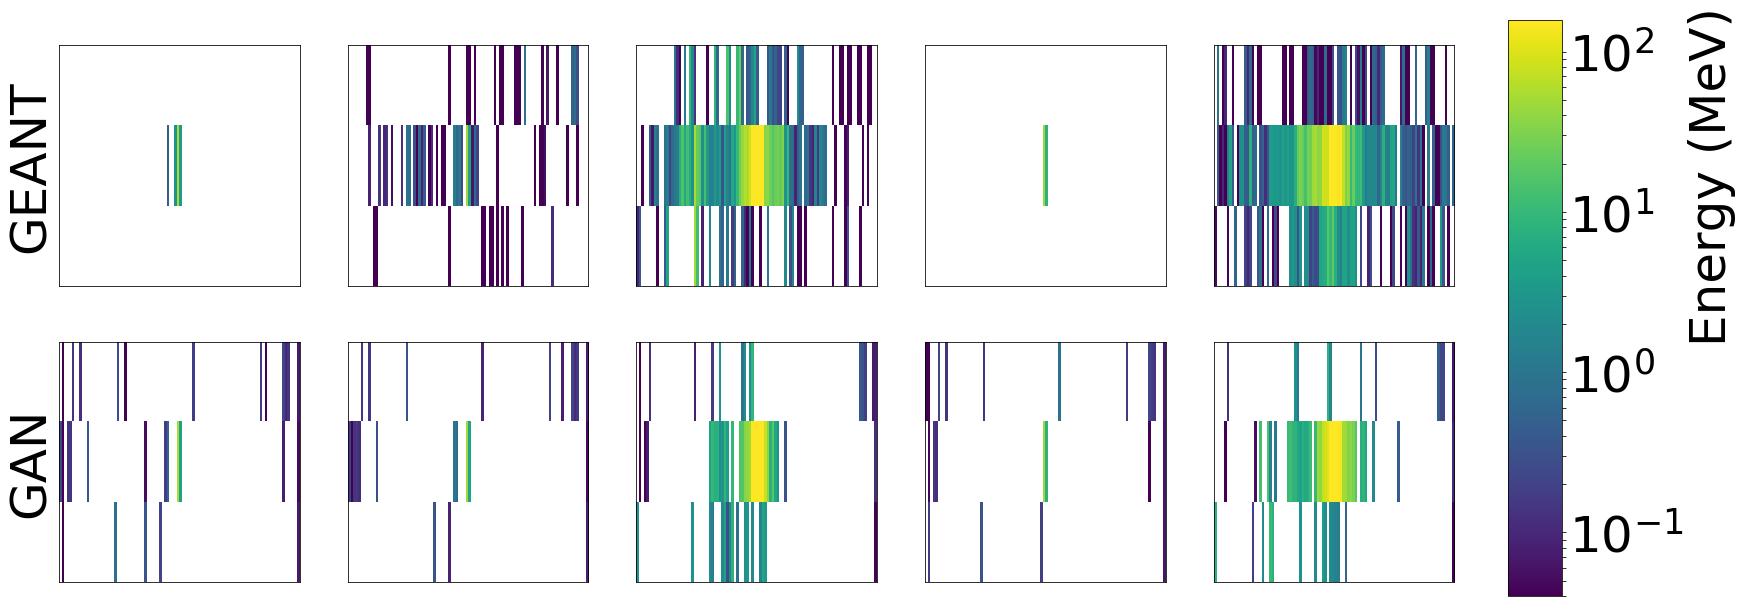

In [78]:
plot_nn(0)

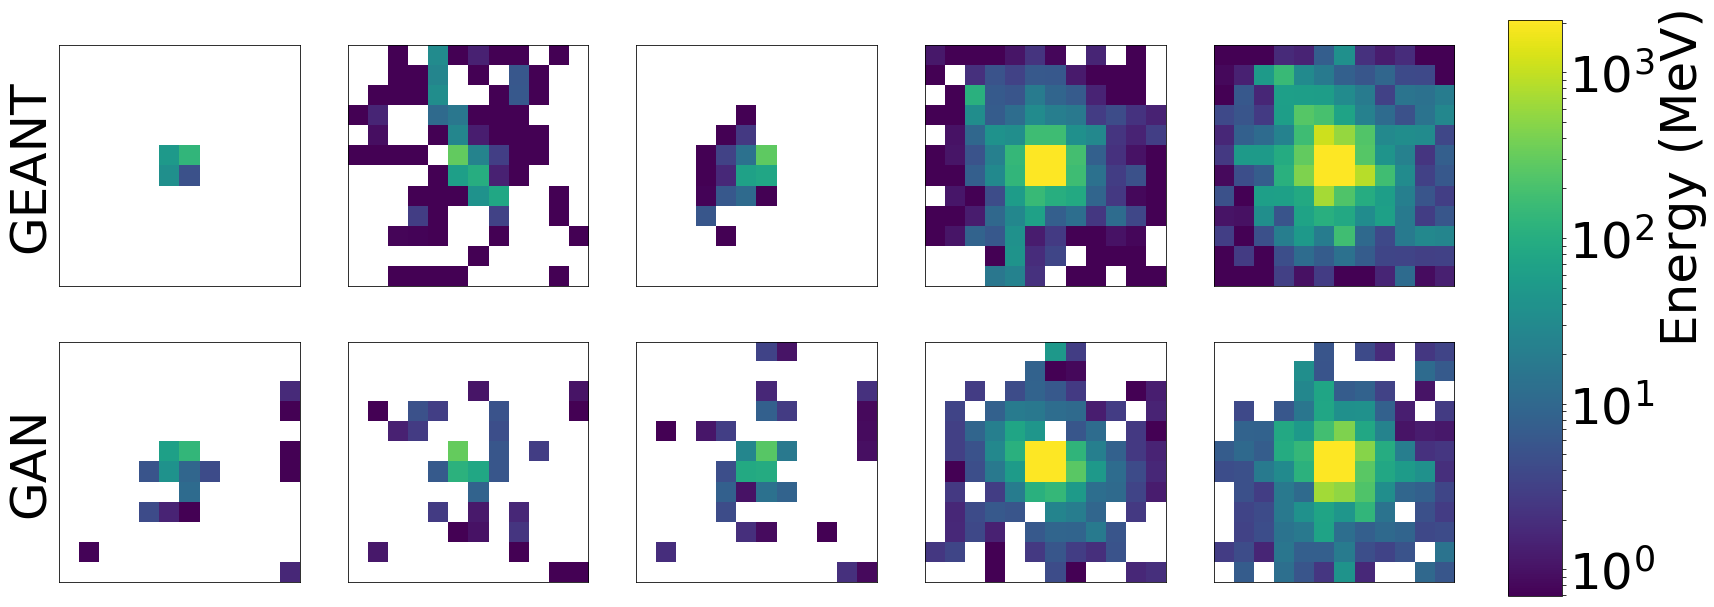

In [82]:
plot_nn(1)

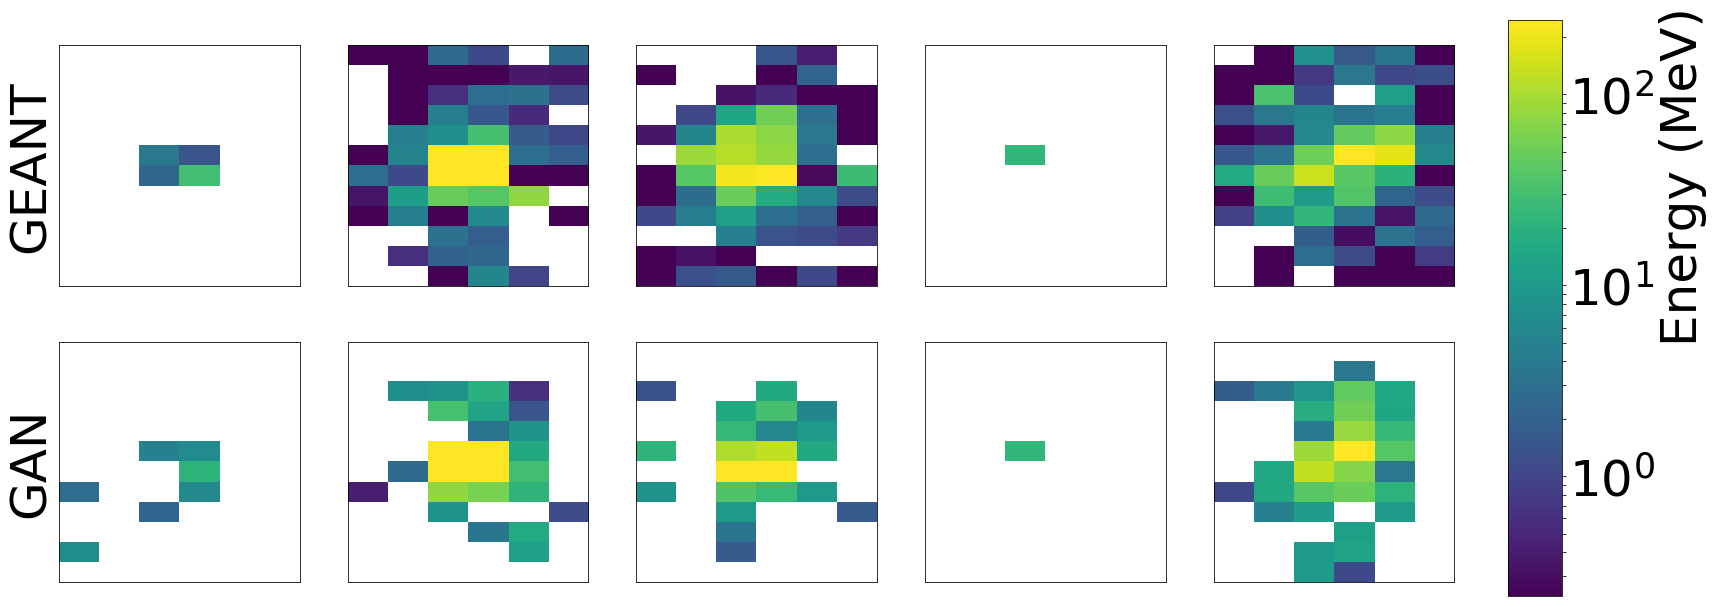

In [92]:
plot_nn(2)

In [6]:
from feats1d import *

In [44]:
dgen_eplus = {
    'layer_0' : np.squeeze(gen_images_eplus[0]),
    'layer_1' : np.squeeze(gen_images_eplus[1]),
    'layer_2' : np.squeeze(gen_images_eplus[2])
}
dgen_gamma = {
    'layer_0' : np.squeeze(gen_images_gamma[0]),
    'layer_1' : np.squeeze(gen_images_gamma[1]),
    'layer_2' : np.squeeze(gen_images_gamma[2])
}
dgen_piplus = {
    'layer_0' : np.squeeze(gen_images_piplus[0]),
    'layer_1' : np.squeeze(gen_images_piplus[1]),
    'layer_2' : np.squeeze(gen_images_piplus[2])
}

In [45]:
matplotlib.rcParams.update({'font.size': 30})

In [46]:
gen_sparsity_eplus = map(lambda x: (x > 0).mean((1, 2)), gen_images_eplus)
real_sparsity_eplus = map(lambda x: (x > 0).mean((1, 2)), real_images_eplus)
gen_sparsity_gamma = map(lambda x: (x > 0).mean((1, 2)), gen_images_gamma)
real_sparsity_gamma = map(lambda x: (x > 0).mean((1, 2)), real_images_gamma)
gen_sparsity_piplus = map(lambda x: (x > 0).mean((1, 2)), gen_images_piplus)
real_sparsity_piplus = map(lambda x: (x > 0).mean((1, 2)), real_images_piplus)

In [47]:
colors = matplotlib.cm.gnuplot2(np.linspace(0.2, 0.8, 3))

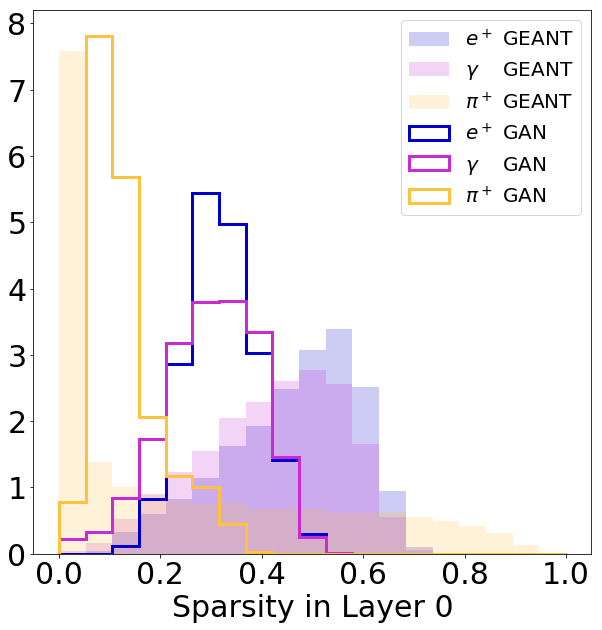

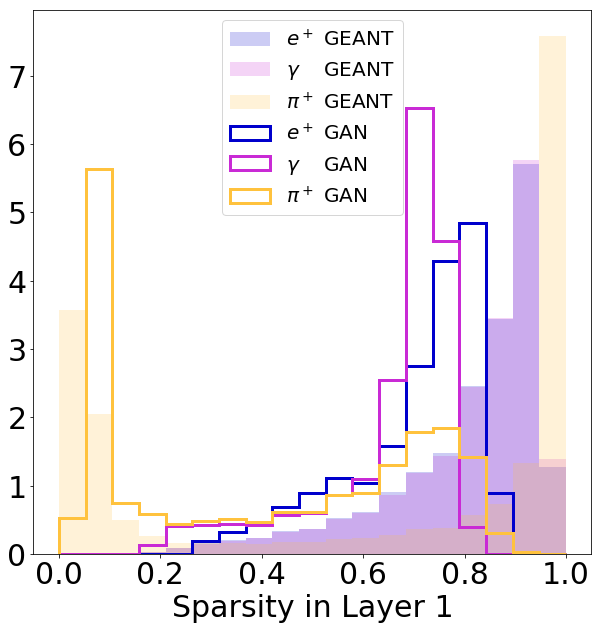

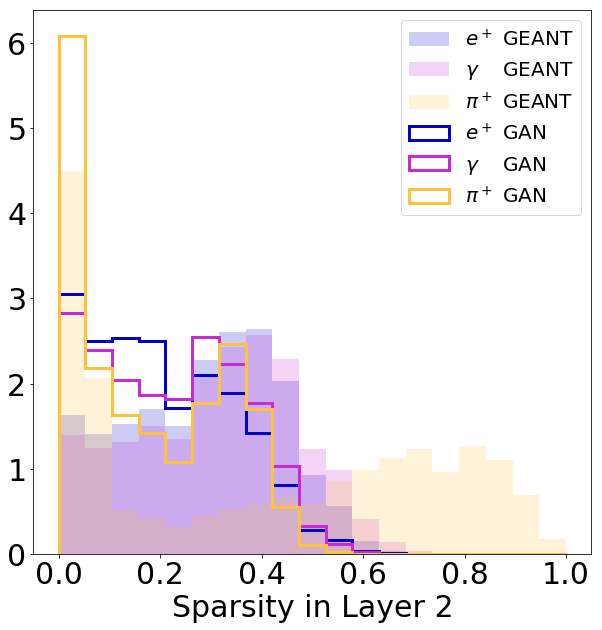

In [119]:
for i in xrange(3):
    bins = np.linspace(0, 1, 20)
    plt.figure(figsize=(10, 10))
    _ = plt.hist(real_sparsity_eplus[i], bins=bins, histtype='stepfilled', linewidth=2,
                 alpha=0.2, normed='True', color=colors[0],
                 label=r'$e^+$ GEANT')
    _ = plt.hist(real_sparsity_gamma[i], bins=bins, histtype='stepfilled', linewidth=2,
                 alpha=0.2, normed='True', color=colors[1],
                 label=r'$\gamma$    GEANT')
    _ = plt.hist(real_sparsity_piplus[i], bins=bins, histtype='stepfilled', linewidth=2,
                 alpha=0.2, normed='True', color=colors[2],
                 label=r'$\pi^+$ GEANT')
    _ = plt.hist(gen_sparsity_eplus[i], bins=bins, histtype='step', linewidth=3,
                 alpha=1, normed='True', color=colors[0],
                 label=r'$e^+$ GAN')
    _ = plt.hist(gen_sparsity_gamma[i], bins=bins, histtype='step', linewidth=3,
                 alpha=1, normed='True', color=colors[1],
                 label=r'$\gamma$    GAN')
    _ = plt.hist(gen_sparsity_piplus[i], bins=bins, histtype='step', linewidth=3,
                 alpha=1, normed='True', color=colors[2],
                 label=r'$\pi^+$ GAN')
    if i==1:
        loc='upper center'
    else:
        loc = 'upper right'
    plt.legend(loc=loc, ncol=1, fontsize=20)#, mode='expand', fontsize=20)
    plt.xlabel('Sparsity in Layer {}'.format(i))
    plt.savefig('sparsity_layer{}.pdf'.format(i))

In [49]:
depth_orig_eplus = depth(d_eplus)
depth_gen_eplus = depth(dgen_eplus)
depth_orig_gamma = depth(d_gamma)
depth_gen_gamma = depth(dgen_gamma)
depth_orig_piplus = depth(d_piplus)
depth_gen_piplus = depth(dgen_piplus)

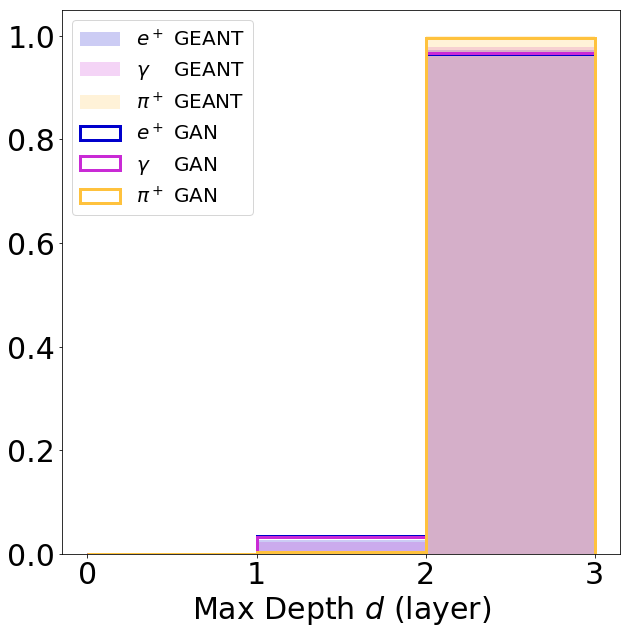

In [146]:
bins = [0, 1, 2, 3]

plt.figure(figsize=(10, 10))
_ = plt.hist(depth_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(depth_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(depth_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(depth_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(depth_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(depth_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')

# _ = plt.hist(depth_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
# _ = plt.hist(depth_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'Max Depth $d$ (layer)')
plt.savefig('max_layer_depth.pdf')

In [51]:
etot_orig_eplus = total_energy(d_eplus)
etot_gen_eplus = total_energy(dgen_eplus)
etot_orig_gamma = total_energy(d_gamma)
etot_gen_gamma = total_energy(dgen_gamma)
etot_orig_piplus = total_energy(d_piplus)
etot_gen_piplus = total_energy(dgen_piplus)

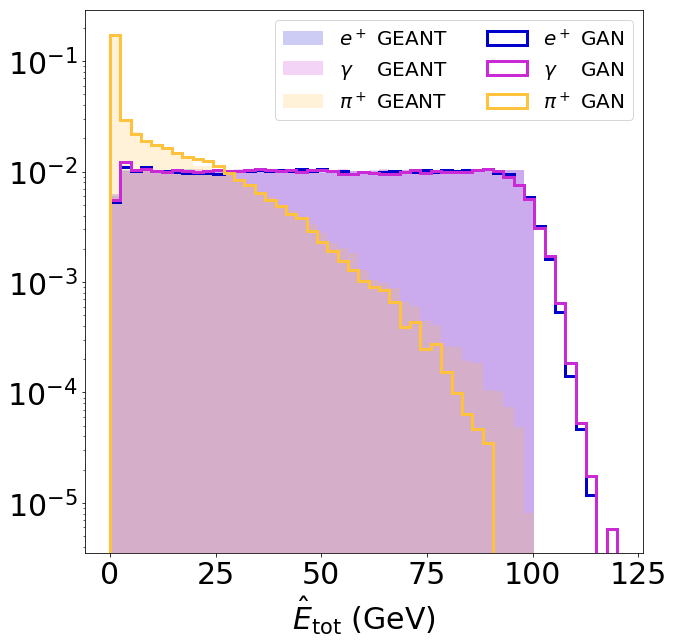

In [147]:
bins = np.linspace(0, 120, 50)
# bins = np.linspace(70000, 75000, 50)
plt.figure(figsize=(10, 10))
_ = plt.hist(etot_orig_eplus / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(etot_orig_gamma / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(etot_orig_piplus / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(etot_gen_eplus / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(etot_gen_gamma / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(etot_gen_piplus / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', fontsize=20, ncol=2)
plt.yscale('log')
plt.xlabel(r'$\hat{E}_\mathrm{tot}$ (GeV)')
plt.savefig('etot.pdf')

In [53]:
e2_orig_eplus = energy('2', d_eplus)
e2_gen_eplus = energy('2', dgen_eplus) 
e1_orig_eplus = energy('1', d_eplus)
e1_gen_eplus = energy('1', dgen_eplus) 
e0_orig_eplus = energy('0', d_eplus)
e0_gen_eplus = energy('0', dgen_eplus)

e2_orig_gamma = energy('2', d_gamma)
e2_gen_gamma = energy('2', dgen_gamma) 
e1_orig_gamma = energy('1', d_gamma)
e1_gen_gamma = energy('1', dgen_gamma) 
e0_orig_gamma = energy('0', d_gamma)
e0_gen_gamma = energy('0', dgen_gamma)

e2_orig_piplus = energy('2', d_piplus)
e2_gen_piplus = energy('2', dgen_piplus) 
e1_orig_piplus = energy('1', d_piplus)
e1_gen_piplus = energy('1', dgen_piplus) 
e0_orig_piplus = energy('0', d_piplus)
e0_gen_piplus = energy('0', dgen_piplus)

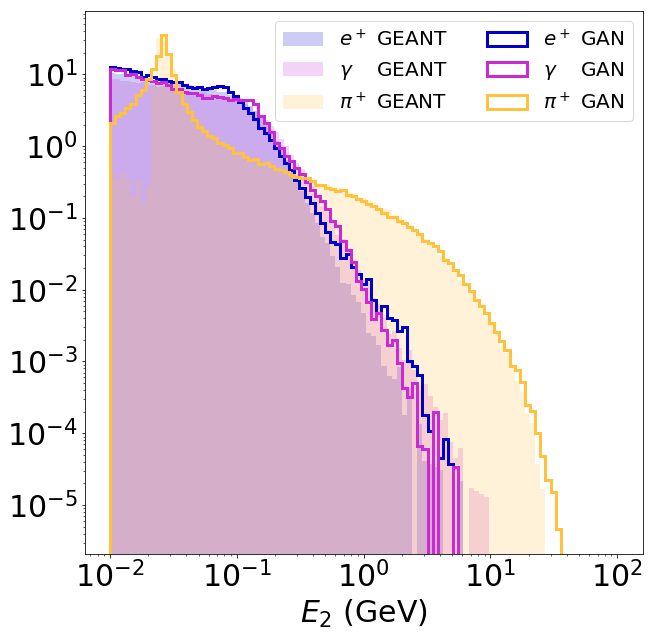

In [123]:
#bins = np.linspace(0, 10000, 100) / 1000
bins=np.logspace(-2, 2, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig_eplus / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e2_orig_gamma / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e2_orig_piplus / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e2_gen_eplus / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e2_gen_gamma / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e2_gen_piplus / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right', fontsize=20, ncol=2)
plt.xlabel(r'$E_2$ (GeV)')
plt.savefig('e2_loglog.pdf')

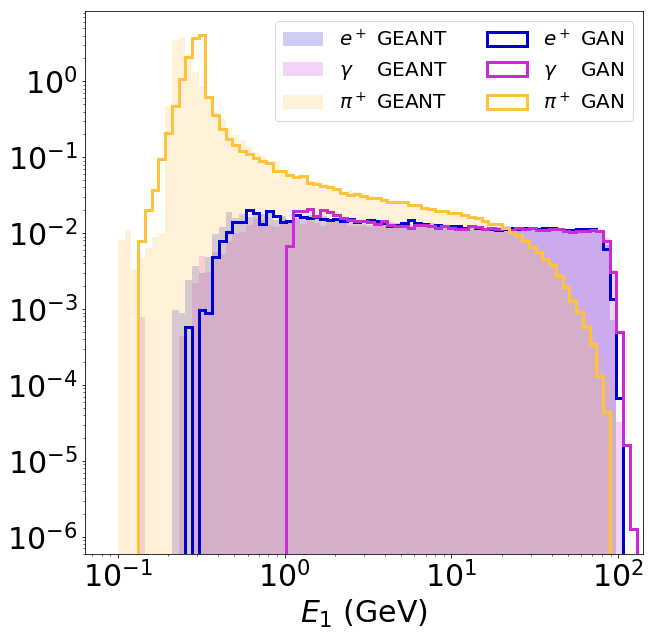

In [124]:
#bins = np.linspace(0, 110000, 100) / 1000
bins=np.logspace(-1, 3, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig_eplus / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e1_orig_gamma / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e1_orig_piplus / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e1_gen_eplus / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e1_gen_gamma / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e1_gen_piplus / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmax=140)

plt.legend(loc='upper right', ncol=2, fontsize=20)
plt.xlabel(r'$E_1$ (GeV)')
plt.savefig('e1_loglog.pdf')

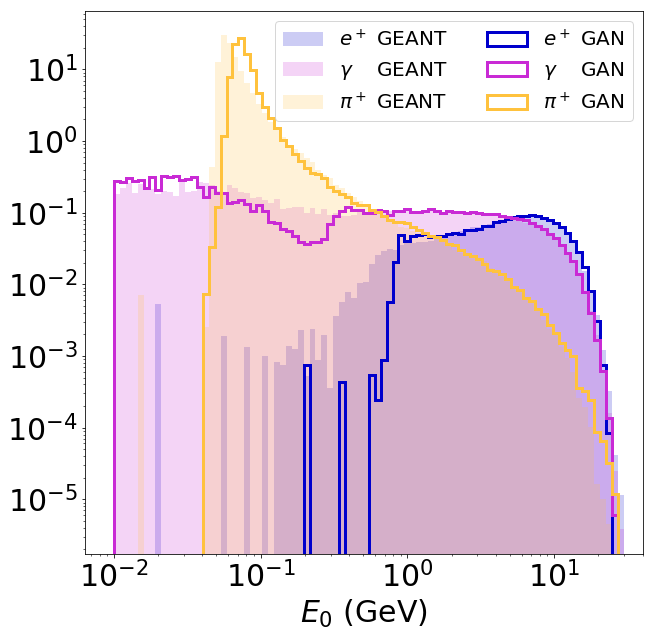

In [125]:
bins=np.logspace(-2, 2, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_eplus / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e0_orig_gamma / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e0_orig_piplus / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e0_gen_eplus / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e0_gen_gamma / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e0_gen_piplus / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmax=40)
plt.legend(loc='upper right', ncol=2, fontsize=20)

plt.xlabel(r'$E_0$ (GeV)')
plt.savefig('e0_loglog.pdf')

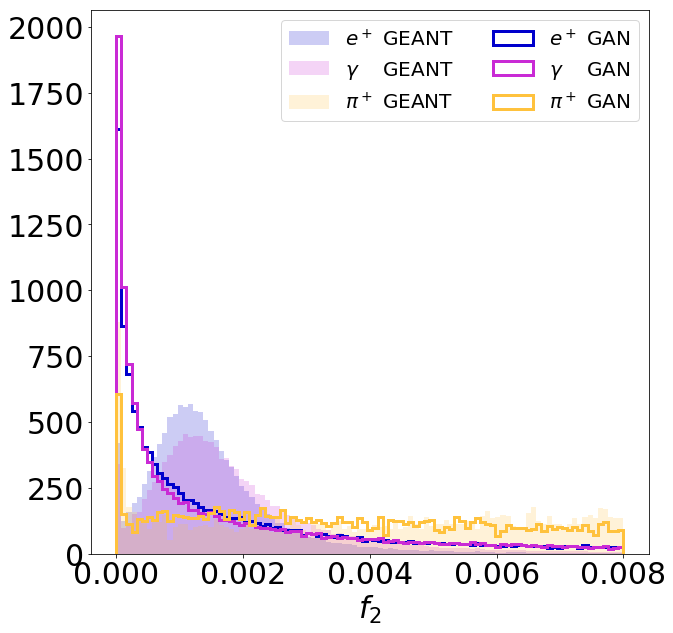

In [141]:
bins = np.linspace(0, 0.008, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig_eplus / etot_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e2_orig_gamma / etot_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e2_orig_piplus / etot_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e2_gen_eplus / etot_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e2_gen_gamma / etot_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e2_gen_piplus / etot_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=2, fontsize=20)

plt.xlabel(r'$f_2$')#$E_2 / E_\mathrm{tot}$')
plt.savefig('e2_etot.pdf')

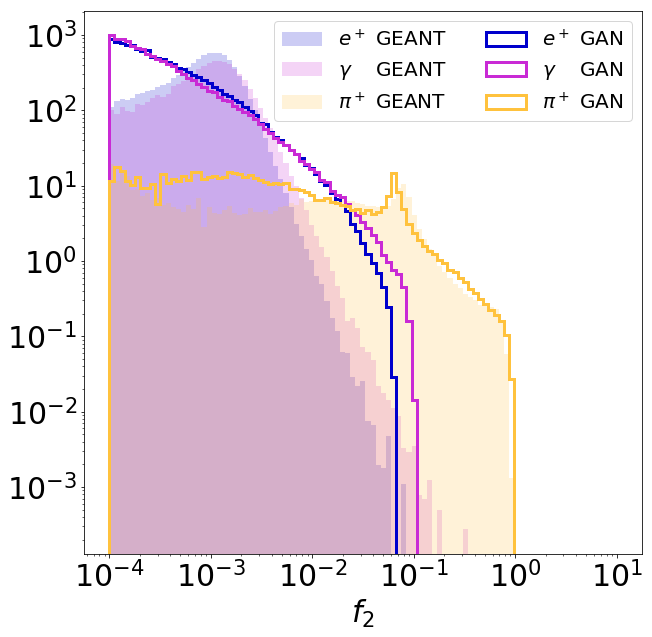

In [142]:
#bins = np.linspace(0, 0.008, 100)
bins = np.logspace(-4, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig_eplus / etot_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e2_orig_gamma / etot_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e2_orig_piplus / etot_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e2_gen_eplus / etot_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e2_gen_gamma / etot_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e2_gen_piplus / etot_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=2, fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$f_2$')#$E_2 / E_\mathrm{tot}$')
plt.savefig('e2_etot_loglog.pdf')



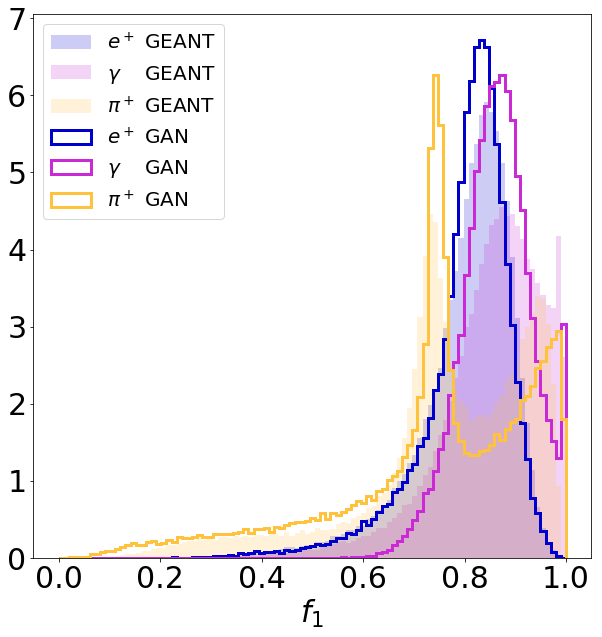

In [143]:
bins = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig_eplus / etot_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e1_orig_gamma / etot_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e1_orig_piplus / etot_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e1_gen_eplus / etot_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e1_gen_gamma / etot_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e1_gen_piplus / etot_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)

plt.xlabel(r'$f_1$')#$E_1 / E_\mathrm{tot}$')
plt.savefig('e1_etot.pdf')

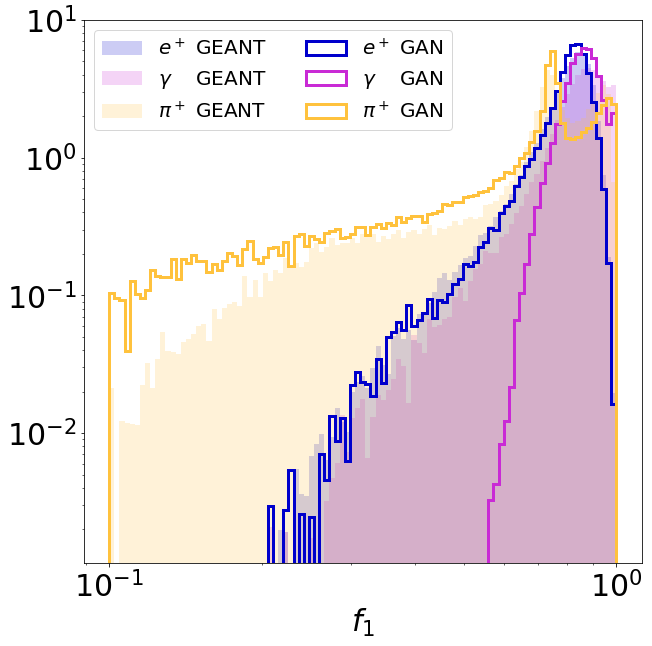

In [140]:
#bins = np.linspace(0, 1, 100)
bins=np.logspace(-1, 0, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig_eplus / etot_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e1_orig_gamma / etot_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e1_orig_piplus / etot_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e1_gen_eplus / etot_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e1_gen_gamma / etot_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e1_gen_piplus / etot_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper left', ncol=2, fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$f_1$')#$E_1 / E_\mathrm{tot}$')
plt.savefig('e1_etot_loglog.pdf')

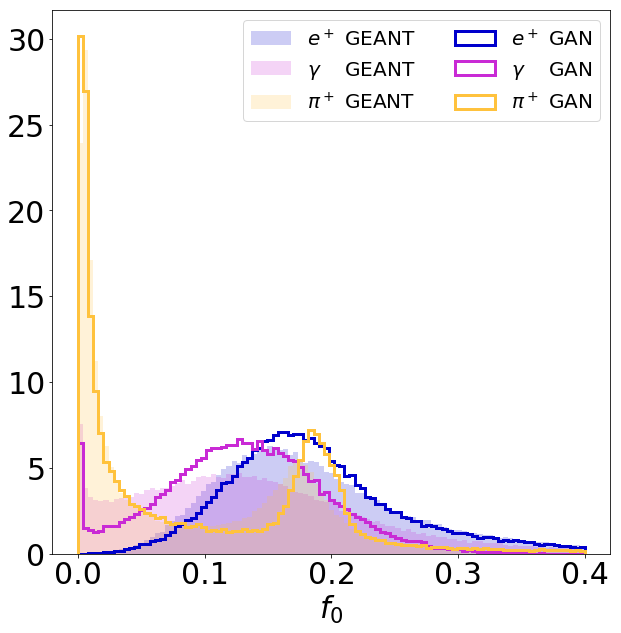

In [139]:
bins = np.linspace(0, 0.4, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_eplus / etot_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e0_orig_gamma / etot_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e0_orig_piplus / etot_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e0_gen_eplus / etot_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e0_gen_gamma / etot_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e0_gen_piplus / etot_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=2, fontsize=20)

plt.xlabel(r'$f_0$')#$E_0 / E_\mathrm{tot}$')
plt.savefig('e0_etot.pdf')

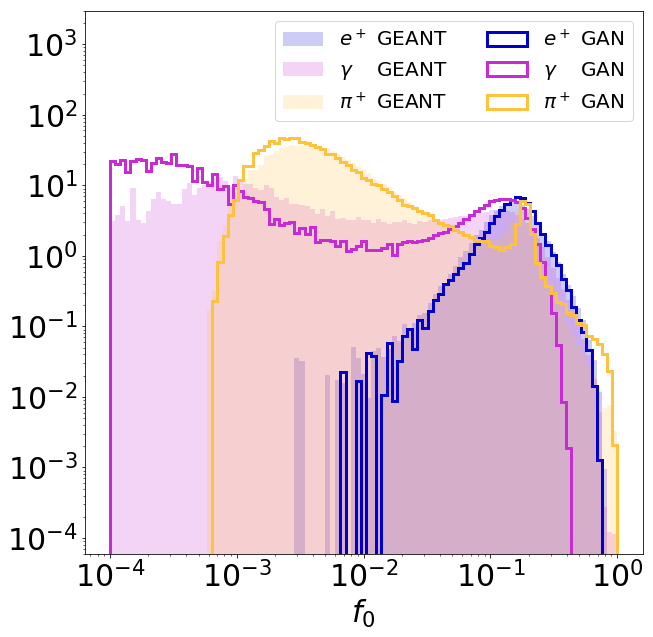

In [144]:
bins = np.logspace(-4, 0, 100) #np.linspace(0, 0.4, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_eplus / etot_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e0_orig_gamma / etot_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e0_orig_piplus / etot_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e0_gen_eplus / etot_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e0_gen_gamma / etot_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e0_gen_piplus / etot_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=2, fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.ylim(ymax=3000)
plt.xlabel(r'$f_0$')#$E_0 / E_\mathrm{tot}$')
plt.savefig('e0_etot_loglog.pdf')

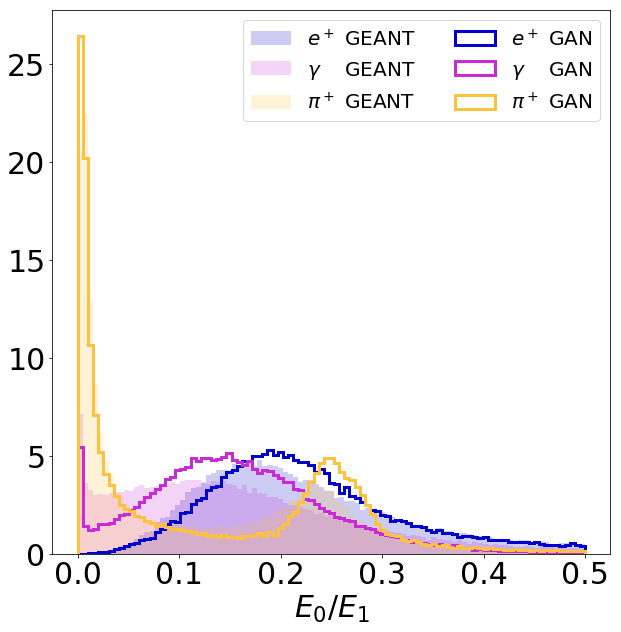

In [63]:
bins = np.linspace(0, 0.5, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_eplus / e1_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e0_orig_gamma / e1_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e0_orig_piplus / e1_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e0_gen_eplus / e1_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e0_gen_gamma / e1_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e0_gen_piplus / e1_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=2, fontsize=20)

plt.xlabel(r'$E_0 / E_1$')

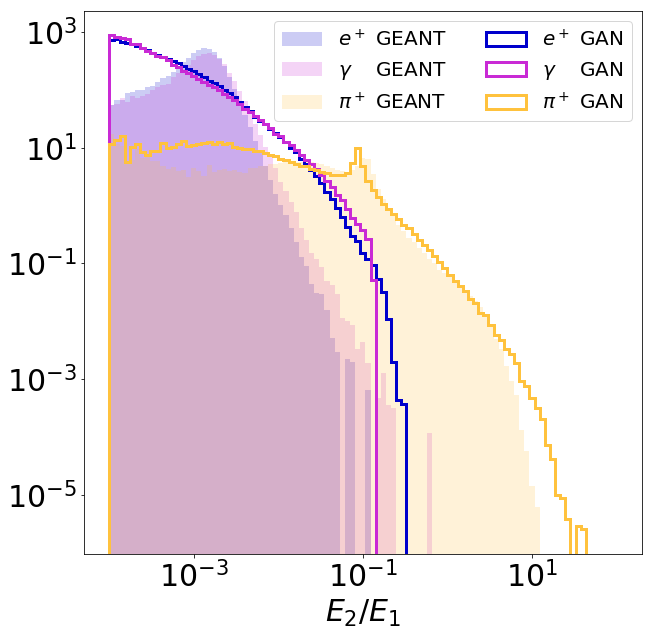

In [64]:
#bins = np.linspace(0, 0.5, 100)
bins = np.logspace(-4, 2, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig_eplus / e1_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e2_orig_gamma / e1_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e2_orig_piplus / e1_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e2_gen_eplus / e1_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e2_gen_gamma / e1_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e2_gen_piplus / e1_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=2, fontsize=20)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$E_2 / E_1$')

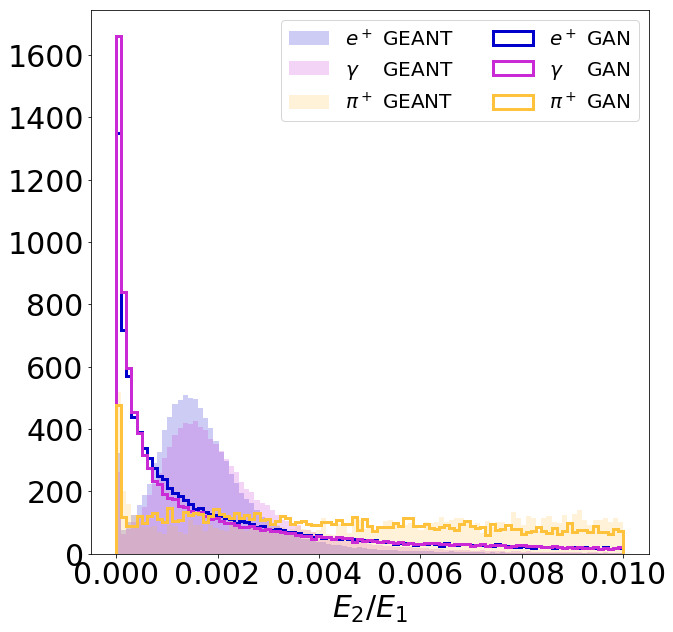

In [65]:
bins = np.linspace(0, 0.01, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig_eplus / e1_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(e2_orig_gamma / e1_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e2_orig_piplus / e1_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(e2_gen_eplus / e1_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(e2_gen_gamma / e1_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(e2_gen_piplus / e1_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=2, fontsize=20)

plt.xlabel(r'$E_2 / E_1$')

In [66]:
lateral_depth_orig_eplus = lateral_depth(d_eplus)
lateral_depth_gen_eplus = lateral_depth(dgen_eplus)
lateral_depth_orig_gamma = lateral_depth(d_gamma)
lateral_depth_gen_gamma = lateral_depth(dgen_gamma)
lateral_depth_orig_piplus = lateral_depth(d_piplus)
lateral_depth_gen_piplus = lateral_depth(dgen_piplus)

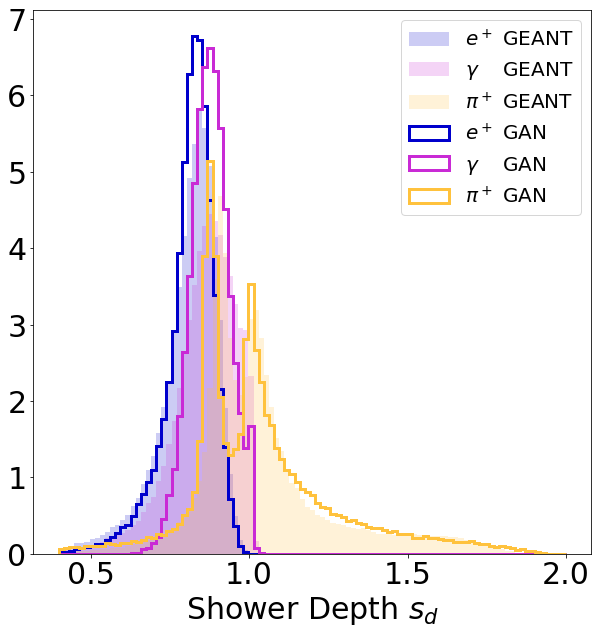

In [150]:
bins = np.linspace(0.4, 2, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_depth_orig_eplus / etot_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(lateral_depth_orig_gamma / etot_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(lateral_depth_orig_piplus / etot_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(lateral_depth_gen_eplus / etot_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(lateral_depth_gen_gamma / etot_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(lateral_depth_gen_piplus / etot_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)

# _ = plt.hist(lateral_depth_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
# _ = plt.hist(lateral_depth_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.xlabel(r'Shower Depth $s_d$')
plt.savefig('shower_depth.pdf')

In [68]:
lateral_depth2_orig_eplus = lateral_depth2(d_eplus)
lateral_depth2_gen_eplus = lateral_depth2(dgen_eplus)
lateral_depth2_orig_gamma = lateral_depth2(d_gamma)
lateral_depth2_gen_gamma = lateral_depth2(dgen_gamma)
lateral_depth2_orig_piplus = lateral_depth2(d_piplus)
lateral_depth2_gen_piplus = lateral_depth2(dgen_piplus)

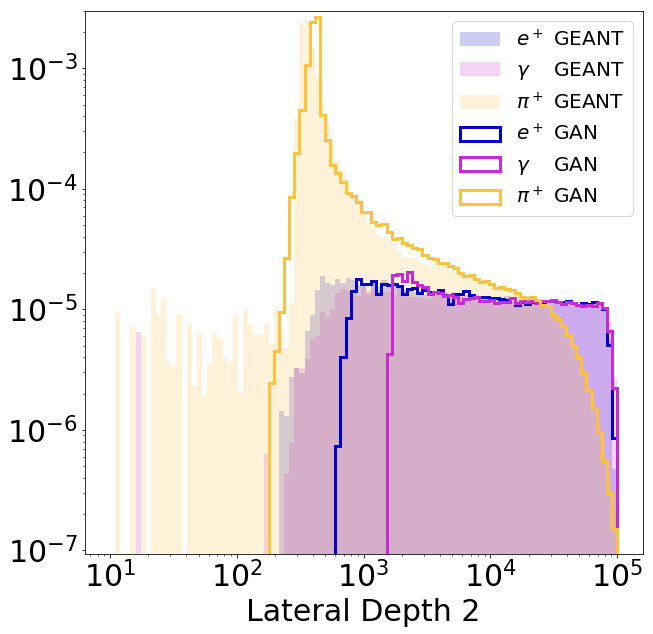

In [133]:
bins = np.logspace(1, 5, 100)#np.linspace(0, 120000, 100)
plt.figure(figsize=(10, 10))

_ = plt.hist(lateral_depth2_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(lateral_depth2_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(lateral_depth2_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(lateral_depth2_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(lateral_depth2_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(lateral_depth2_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.ylim(ymax=0.003)
plt.xlabel(r'Lateral Depth 2')
plt.savefig('lateral_depth_2.pdf')

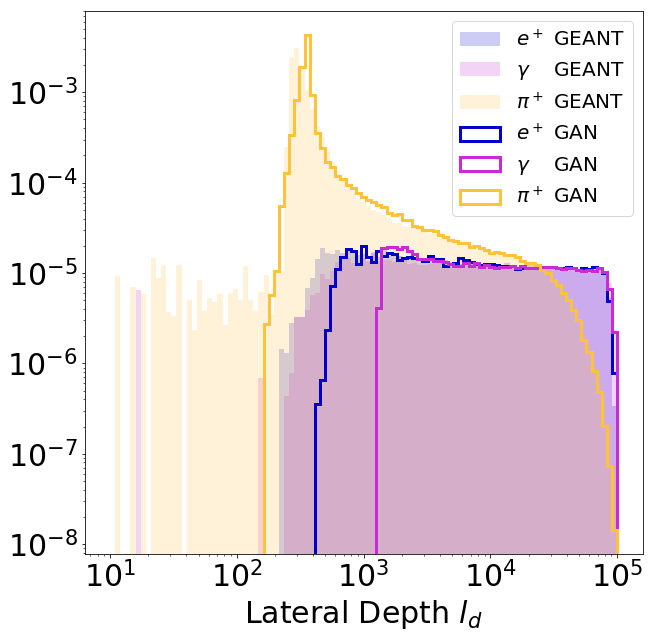

In [151]:
# shower depth
bins = np.logspace(1, 5, 100)#np.linspace(0, 120000, 100)
plt.figure(figsize=(10, 10))

_ = plt.hist(lateral_depth_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(lateral_depth_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(lateral_depth_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(lateral_depth_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(lateral_depth_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(lateral_depth_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'Lateral Depth $l_d$')
plt.savefig('lateral_depth.pdf')

In [85]:
shower_depth_width_orig_eplus = shower_depth_width(
    lateral_depth_orig_eplus, lateral_depth2_orig_eplus, etot_orig_eplus)
shower_depth_width_gen_eplus = shower_depth_width(
    lateral_depth_gen_eplus, lateral_depth2_gen_eplus, etot_gen_eplus)

shower_depth_width_orig_gamma = shower_depth_width(
    lateral_depth_orig_gamma, lateral_depth2_orig_gamma, etot_orig_gamma)
shower_depth_width_gen_gamma = shower_depth_width(
    lateral_depth_gen_gamma, lateral_depth2_gen_gamma, etot_gen_gamma)

shower_depth_width_orig_piplus = shower_depth_width(
    lateral_depth_orig_piplus, lateral_depth2_orig_piplus, etot_orig_piplus)
shower_depth_width_gen_piplus = shower_depth_width(
    lateral_depth_gen_piplus, lateral_depth2_gen_piplus, etot_gen_piplus)


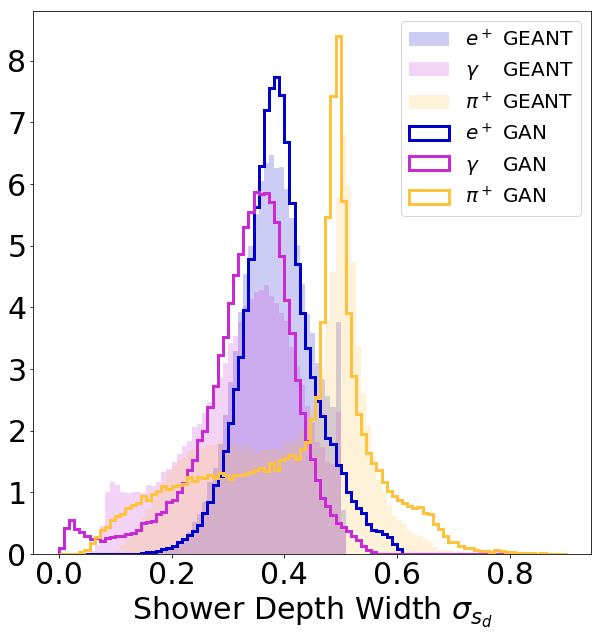

In [153]:
# shower depth width
bins = np.linspace(0, 0.9, 100)
plt.figure(figsize=(10, 10))

_ = plt.hist(shower_depth_width_orig_eplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(shower_depth_width_orig_gamma, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(shower_depth_width_orig_piplus, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(shower_depth_width_gen_eplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(shower_depth_width_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(shower_depth_width_gen_piplus, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'Shower Depth Width $\sigma_{s_d}$')
plt.savefig('shower_depth_width.pdf')

In [90]:
lateral_width0_orig_eplus = layer_lateral_width('0', d_eplus)
lateral_width1_orig_eplus = layer_lateral_width('1', d_eplus)
lateral_width2_orig_eplus = layer_lateral_width('2', d_eplus)
lateral_width0_gen_eplus = layer_lateral_width('0', dgen_eplus)
lateral_width1_gen_eplus = layer_lateral_width('1', dgen_eplus)
lateral_width2_gen_eplus = layer_lateral_width('2', dgen_eplus)

lateral_width0_orig_gamma = layer_lateral_width('0', d_gamma)
lateral_width1_orig_gamma = layer_lateral_width('1', d_gamma)
lateral_width2_orig_gamma = layer_lateral_width('2', d_gamma)
lateral_width0_gen_gamma = layer_lateral_width('0', dgen_gamma)
lateral_width1_gen_gamma = layer_lateral_width('1', dgen_gamma)
lateral_width2_gen_gamma = layer_lateral_width('2', dgen_gamma)

lateral_width0_orig_piplus = layer_lateral_width('0', d_piplus)
lateral_width1_orig_piplus = layer_lateral_width('1', d_piplus)
lateral_width2_orig_piplus = layer_lateral_width('2', d_piplus)
lateral_width0_gen_piplus = layer_lateral_width('0', dgen_piplus)
lateral_width1_gen_piplus = layer_lateral_width('1', dgen_piplus)
lateral_width2_gen_piplus = layer_lateral_width('2', dgen_piplus)

feats1d.py:119: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((x2 / e) - (x / e) ** 2)
feats1d.py:119: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((x2 / e) - (x / e) ** 2)


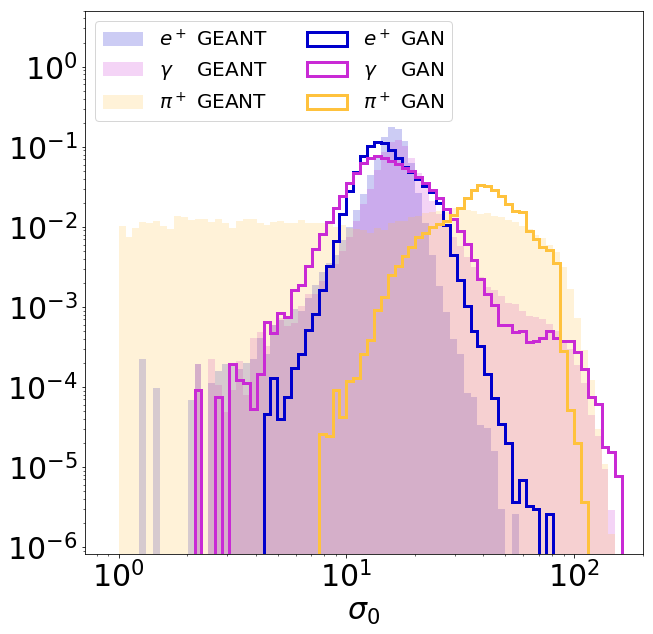

In [154]:
# layer 0 lateral width
bins = np.logspace(0, 3, 100)#np.linspace(0, 100, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width0_orig_eplus[np.isfinite(lateral_width0_orig_eplus)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(lateral_width0_orig_gamma[np.isfinite(lateral_width0_orig_gamma)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(lateral_width0_orig_piplus[np.isfinite(lateral_width0_orig_piplus)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(lateral_width0_gen_eplus[np.isfinite(lateral_width0_gen_eplus)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(lateral_width0_gen_gamma[np.isfinite(lateral_width0_gen_gamma)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(lateral_width0_gen_piplus[np.isfinite(lateral_width0_gen_piplus)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper left', ncol=2, fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=5)
plt.xlim(xmax=200)
plt.xlabel(r'$\sigma_0$')
plt.savefig('lateral_width_layer0.pdf')

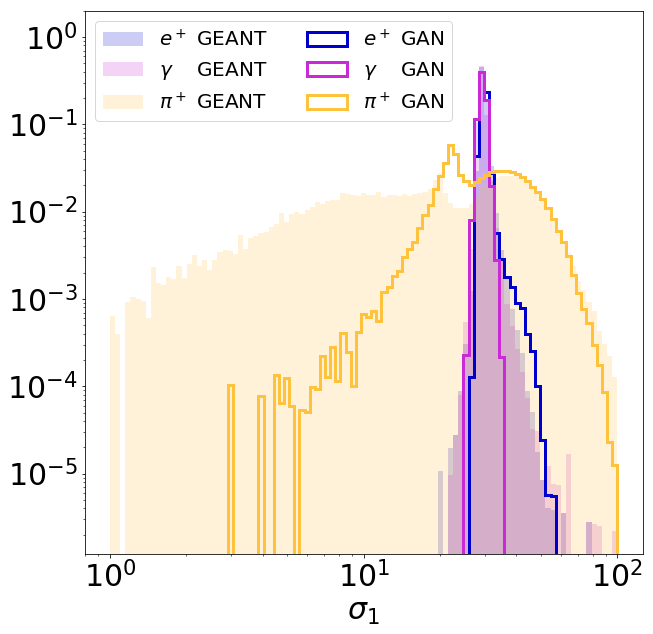

In [155]:
# layer 1 lateral width
bins = np.logspace(0, 2, 100)#np.linspace(0, 70, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width1_orig_eplus[np.isfinite(lateral_width1_orig_eplus)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(lateral_width1_orig_gamma[np.isfinite(lateral_width1_orig_gamma)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(lateral_width1_orig_piplus[np.isfinite(lateral_width1_orig_piplus)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(lateral_width1_gen_eplus[np.isfinite(lateral_width1_gen_eplus)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(lateral_width1_gen_gamma[np.isfinite(lateral_width1_gen_gamma)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(lateral_width1_gen_piplus[np.isfinite(lateral_width1_gen_piplus)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper left', ncol=2, fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=2)
plt.xlabel(r'$\sigma_1$')
plt.savefig('lateral_width_layer1.pdf')

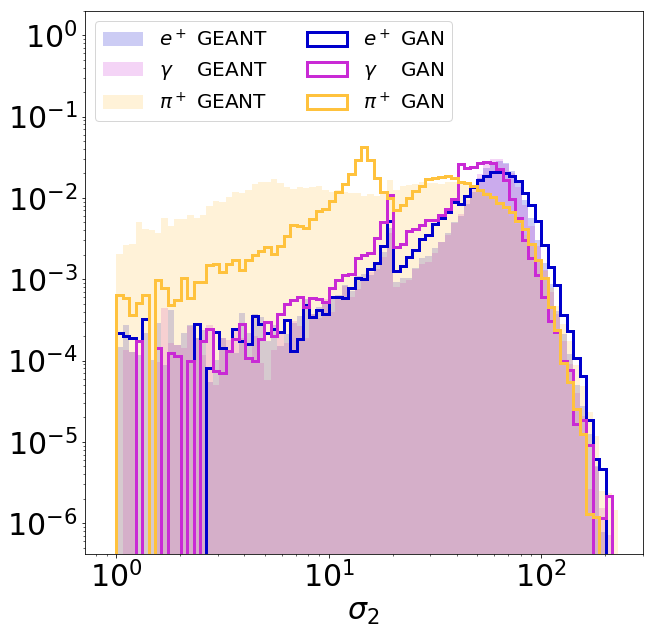

In [156]:
# layer 2 lateral width
# layer 1 lateral width
bins = np.logspace(0, 3, 100)#np.linspace(0, 200, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(lateral_width2_orig_eplus[np.isfinite(lateral_width2_orig_eplus)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(lateral_width2_orig_gamma[np.isfinite(lateral_width2_orig_gamma)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(lateral_width2_orig_piplus[np.isfinite(lateral_width2_orig_piplus)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(lateral_width2_gen_eplus[np.isfinite(lateral_width2_gen_eplus)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(lateral_width2_gen_gamma[np.isfinite(lateral_width2_gen_gamma)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(lateral_width2_gen_piplus[np.isfinite(lateral_width2_gen_piplus)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
plt.legend(loc='upper left', ncol=2, fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=2)
plt.xlim(xmax=300)
plt.xlabel(r'$\sigma_2$')
plt.savefig('lateral_width_layer2.pdf')

In [170]:
real_images_eplus[0][0].shape

(3, 96)

In [191]:
def eratio(images):
    top2 = np.array([np.sort(row.ravel())[::-1][:2] for row in images])
    return (top2[:, 0] - top2[:, 1]) / (top2[:, 0] + top2[:, 1])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


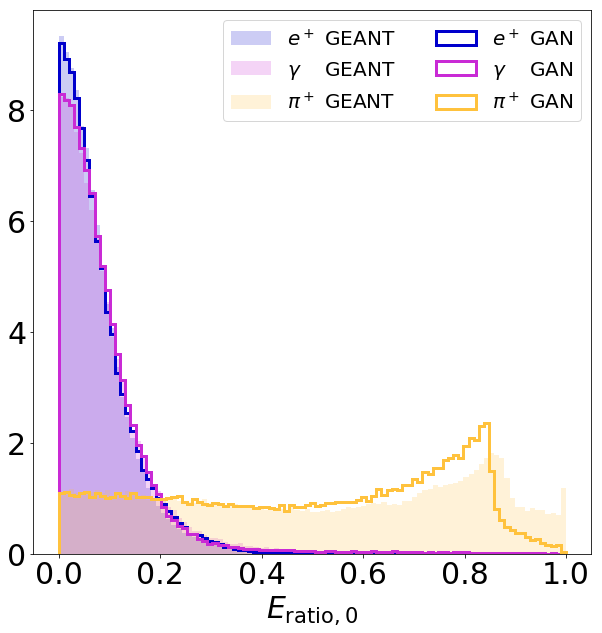

In [214]:
#bins=np.logspace(-2, 2, 100)
bins=np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(eratio(real_images_eplus[0]), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(eratio(real_images_gamma[0])[np.isfinite(eratio(real_images_gamma[0]))],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(eratio(real_images_piplus[0]), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(eratio(gen_images_eplus[0]), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(eratio(gen_images_gamma[0])[np.isfinite(eratio(gen_images_gamma[0]))],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(eratio(gen_images_piplus[0]), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(xmax=40)
plt.legend(loc='upper right', ncol=2, fontsize=20)

plt.xlabel(r'$E_{\mathrm{ratio},0}$')
plt.savefig('eratio.pdf')

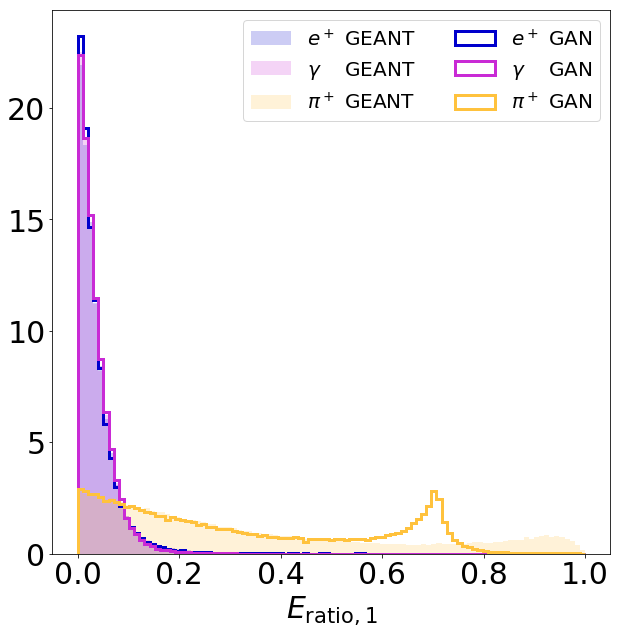

In [213]:
#bins=np.logspace(-2, 2, 100)
bins=np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(eratio(real_images_eplus[1]), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(eratio(real_images_gamma[1])[np.isfinite(eratio(real_images_gamma[1]))],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(eratio(real_images_piplus[1]), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(eratio(gen_images_eplus[1]), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(eratio(gen_images_gamma[1])[np.isfinite(eratio(gen_images_gamma[1]))],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(eratio(gen_images_piplus[1]), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(xmax=40)
plt.legend(loc='upper right', ncol=2, fontsize=20)

plt.xlabel(r'$E_{\mathrm{ratio},1}$')
plt.savefig('eratio1.pdf')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


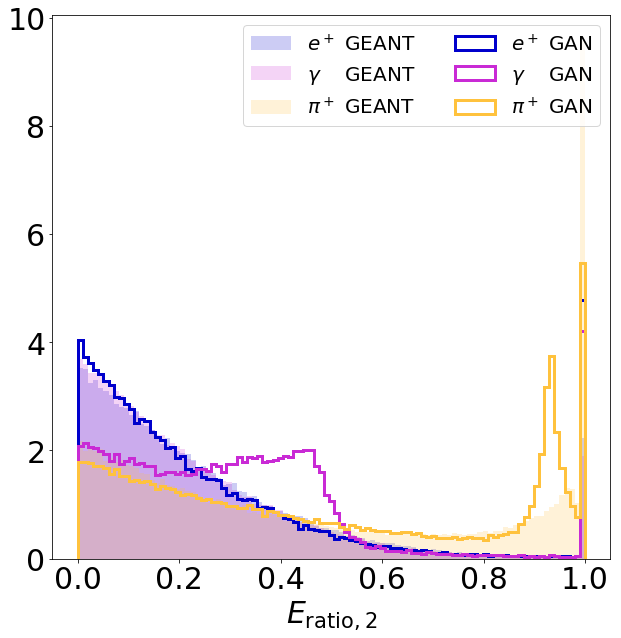

In [212]:
#bins=np.logspace(-2, 2, 100)
bins=np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(eratio(real_images_eplus[2])[np.isfinite(eratio(real_images_eplus[2]))],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$e^+$ GEANT')
_ = plt.hist(eratio(real_images_gamma[2])[np.isfinite(eratio(real_images_gamma[2]))],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(eratio(real_images_piplus[2])[np.isfinite(eratio(real_images_piplus[2]))],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[2],
             label=r'$\pi^+$ GEANT')
_ = plt.hist(eratio(gen_images_eplus[2])[np.isfinite(eratio(gen_images_eplus[2]))],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'$e^+$ GAN')
_ = plt.hist(eratio(gen_images_gamma[2])[np.isfinite(eratio(gen_images_gamma[2]))],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[1],
             label=r'$\gamma$    GAN')
_ = plt.hist(eratio(gen_images_piplus[2])[np.isfinite(eratio(gen_images_piplus[2]))],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[2],
             label=r'$\pi^+$ GAN')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(xmax=40)
plt.legend(loc='upper right', ncol=2, fontsize=20)

plt.xlabel(r'$E_{\mathrm{ratio},2}$')
plt.savefig('eratio2.pdf')